## Fundamental Diagram

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import gzip
import datetime as dt
from os import listdir
from os.path import isfile, join
import time
import itertools

from operator import itemgetter 

import matplotlib.pyplot as plt

import bokeh.io as bkio
import bokeh.plotting as bkplot
import bokeh.models as bkmod
import bokeh.layouts as bklay

from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('../')

import trafficpassion.timer as timer

In [5]:
bkplot.output_notebook()

Loading BokehJS ...

In [338]:
data_path = '../../../data/'
data_file = data_path + 'I5S_data2.csv'

meta_path = '../../../data/meta/2015/d11/'
meta_file = meta_path + 'd11_text_meta_2015_12_17.txt'

output_path = '../graphs/'

### Load data

In [402]:
colnames = ['Idx', 'Date', 'Time', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length',
                     'Samples', '% Observed', 'TotalFlow', 'AvgOccupancy', 'AvgSpeed', 'Lat', 'Lon', 'Order']

t0 = time.time()
df = pd.read_csv( data_file, header=None, skiprows=1 )
df.columns = colnames

df.drop( ['District', 'Freeway #', 'Direction', 'Lane Type', 
       'Station Length', 'Samples', '% Observed', 'Lat', 'Lon', 'Idx'], 
        axis=1, inplace=True)

print timer.timestr( time.time()-t0 )

df.shape

26.05 sec


(10773178, 7)

In [381]:
t0 = time.time()
meta_df = pd.read_csv( meta_file, delimiter='\t' ) \
    .rename( columns={'ID':'Station'}) \
    .set_index('Station')
print timer.timestr( time.time()-t0 )

meta_df.shape

0.01 sec


(1424, 17)

### Merge lane data

In [403]:
df = df.join( meta_df['Lanes'], on='Station' )

print 'missing metadata for stations: ', df.loc[df.Lanes.isnull()].Station.unique().tolist()

df = df.dropna()

missing metadata for stations:  [1121740]


### Free flow vs synchronized

##### Line F

$V_{min}^{free} = \frac{q_{max}^{free}}{\rho_{max}^{free}} \implies \rho_{max}^{free} = \frac{q_{max}^{free}}{V_{min}^{free}}$ 

We can calculate the $ \rho_{max}^{free}$ by assuming the maximum flow value we find is $ q_{max}^{free}$ and by estimating the minimum average speed of free-flow  $ V_{min}^{free}$

$\text{velocity (ie. slope of F line) } = \frac{\text{ max flow }}{\text{ max density }} \implies \frac{q_{max}^{free}}{\rho_{max}^{free}}$


-----

##### Line J
Per-lane equations

$q(\rho) = \frac{1}{\tau_{delay}}(1 - \frac{\rho}{\rho_{max}^{jam}} )$

$\rho_{min} = \frac{\frac{1}{\tau_{delay}}}{\frac{1}{\tau_{delay}*\rho_{max}^{jam}}+\frac{q_{max}^{free}}{\rho_{max}^{free}}}$

$q_{out} = \frac{1}{\tau_{delay}}(1 - \frac{\rho_{min}}{\rho_{max}^{jam}} )$

### Problems

* How do we estimate the maximum density of a jam: $\text{ }\rho_{max}^{jam}$?  
Both $ \rho_{min} $ and $ q_{out} $ (the line J) rely on this value for calculations. 
(_Note:_ I don't think we can rely on the maximum empirical value of density for this)
>[...] traffic flow stops completely, usually in the range of 185–250 vehicles per mile per lane [[citation needed]](https://en.wikipedia.org/wiki/Traffic_flow)

* Is there an approach for objectively determining the slope of the line F ($v_{min}^{free}$)?  
Using `df.AvgSpeed.mean() - df.AvgSpeed.std()` seems to given an OK approximation.  
A couple of the whitepapers mention fixing it to a value, ie. `55 mph`  
Perhaps we use `mean - std` and also set a floor value for the slope at 55?


* Several whitepapers estimate the slope of the line J ($v_g$ or $w$) to be somewhere between 9 and 11 mph.  
The slope of the line J represents the speed at which the downstream front (wave) moves upstream.


* The stability point ($q_{out}$) cannot be above the limit point ($q_{max}^{free}$), however that appears to occur in several of the misbehaved graphs.


### Plotting Function

In [391]:
'''

valid kwargs:
    j_line
    f_line
    lim_note
    sta_note
    lim_line
    sta_line
    slope
'''
def plt_fund_diag( df, title, to_file=None, xlim=None, ylim=None, **kwargs ):
    assert 'TotalFlow' in df.columns, 'DataFrame must have TotalFlow column'
    assert 'AvgSpeed' in df.columns, 'DataFrame must have AvgSpeed column'
    assert 'Lanes' in df.columns, 'DataFrame must have Lanes column'
    
    def getarg( arg ):
        return None if arg not in kwargs else kwargs[arg]
    
    limit_color = 'cyan'
    stable_color = 'magenta'
    
    plt.set_cmap('Set1')
    fig = plt.figure(figsize = (10,5))
    plt.title( title )
    ax = fig.add_subplot(1, 1, 1)
    
    if xlim and (len(xlim)==2):
        xlim_min = xlim[0] if xlim[0] else xmin
        xlim_max = xlim[1] if xlim[1] else xmax
        ax.set_xlim( (xlim_min, xlim_max))
    if ylim and (len(ylim)==2):
        ylim_min = ylim[0] if ylim[0] else ymin
        ylim_max = ylim[1] if ylim[1] else ymax
        ax.set_ylim( (ylim_min, ylim_max))
    
    xlim_min, xlim_max = ax.get_xlim()
    ylim_min, ylim_max = ax.get_ylim()
    
    flow = df['TotalFlow'] * 12   #convert from cars/5-min to cars/hr
    x, y = flow/df['AvgSpeed'], flow
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    q_free_max = ymax
    q_min = ymin
    
    # How many lanes?  (use max if this df is represents more than one station)
    n_lanes = int(df.Lanes.max())
    
    p_jam_max = 200 * n_lanes  #200 is an estimate for max density per lane per mile
    #p_jam_max = xmax
    
    v_free_min = df['AvgSpeed'].mean() - df['AvgSpeed'].std()

    p_free_max = (q_free_max/v_free_min)
    
    t_delay = 2.0/3600 #time delay before acceleration in hours
    
    def line_f( p ):
        f = lambda x: x*(q_free_max/p_free_max)
        #f = lambda x: x * 55  #WE CAN SET A FIXED SLOPE
        if type(p)==type([]):
            return map(f, p)
        return f(p)
    
    def line_j( p ):
        f = lambda x: (n_lanes/t_delay)*(1 - (x/p_jam_max))
        if type(p)==type([]):
            return map(f, p)
        return f(p)
    
    p_min = (n_lanes/t_delay)/((n_lanes/(t_delay*p_jam_max))+(q_free_max/p_free_max))
    q_out = line_j(p_min)
        
    fx = [xmin, p_free_max]
    fy = line_f( fx )

    jx = [0, p_jam_max]
    jy = line_j( jx )
    
    ax.scatter( x, y, s=10, alpha=0.1, label='Station Meas.' )
    
    ax.scatter( p_free_max, q_free_max, s=20, color=limit_color, label='Limit Point')
    ax.scatter( p_min, q_out, s=20, color=stable_color, label='Stable/Metastable')
    
    if getarg('f_line') != False:
        ax.plot( fx, fy, 'r-', label='F Line' )
        
    if getarg('j_line') != False:
        ax.plot( jx, jy, 'g--', label='J Line' )
    
    if getarg('lim_line') != False:
        ax.plot( [xlim_min, p_free_max], [q_free_max, q_free_max], color=limit_color, linestyle='--' )
        ax.plot( [p_free_max, p_free_max], [ylim_min, q_free_max], color=limit_color, linestyle='--' )

    if getarg('sta_line') != False:
        ax.plot( [xlim_min, p_min], [q_out, q_out], color=stable_color, linestyle='--' )
        ax.plot( [p_min, p_min], [ylim_min, q_out], color=stable_color, linestyle='--' )
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=1)
    
    label = r'$(\rho_{{max}}^{{free}}\approx{:.5f}, q_{{max}}^{{free}}\approx{:.1f})$'.format(p_free_max, q_free_max)
    if getarg('lim_note') != False:
        plt.annotate( label, xy=(p_free_max, q_free_max), xytext=(-5, 7), bbox=bbox_props,
            textcoords='offset points', ha='right', va='bottom')
    
    label = r'$(\rho_{{min}}\approx{:.5f}, q_{{out}}\approx{:.1f})$'.format(p_min, q_out)
    if getarg('sta_note') != False:
        plt.annotate( label, xy=(p_min, q_out), xytext=(-5, 7), bbox=bbox_props,
            textcoords='offset points', ha='right', va='bottom')
        
    vf = (fy[1]-fy[0])/(fx[1]-fx[0])
    vg = (jy[1]-jy[0])/(jx[1]-jx[0])
    label = r'$line_{{f}} = {:.1f} mph$  $line_{{j}} = {:.1f} mph$'.format(vf, vg)
    if getarg('slope') != False:
        plt.annotate( label, xy=(xlim_min, ylim_min), ha='left', va='top')
        
    label = r'$n_{{lanes}} = {}$'.format(n_lanes)
    if getarg('lanes') != False:
        plt.annotate( label, xy=(p_jam_max, line_j(p_jam_max)), ha='right', va='top')
    
    ax.set_xlabel('Density (veh/mi)'), ax.set_ylabel('Flow (veh/hr)')
    
    plt.legend( fontsize='x-small' )
    
    if to_file != None:
        fig.savefig( output_path + 'fund_diag/'+ to_file ) 
    else:
        plt.show()
    plt.close( fig )

### Downsample

In [207]:
sample_size = 0.1

sub_df, _ = train_test_split( df[df.Station==1114261], train_size=sample_size, random_state=15 )
print 'shape:', sub_df.shape

shape: (10478, 7)


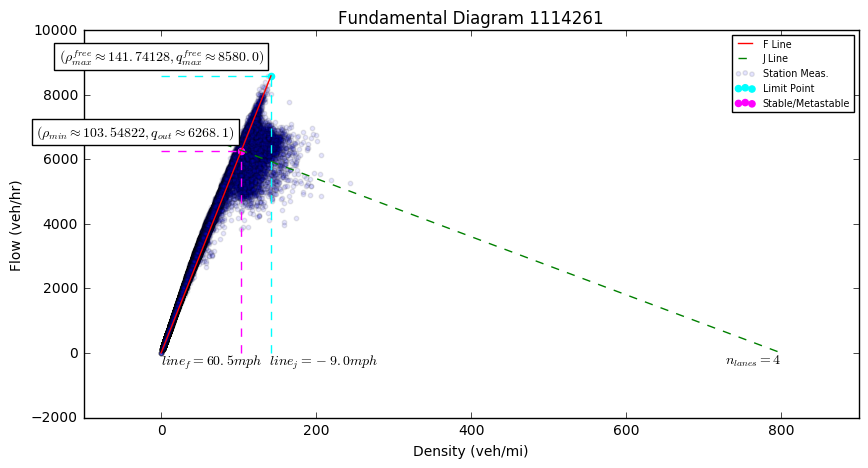

In [392]:
station = 1114261
plt_fund_diag( df[df.Station==station], 'Fundamental Diagram {}'.format(station) )

# All stations

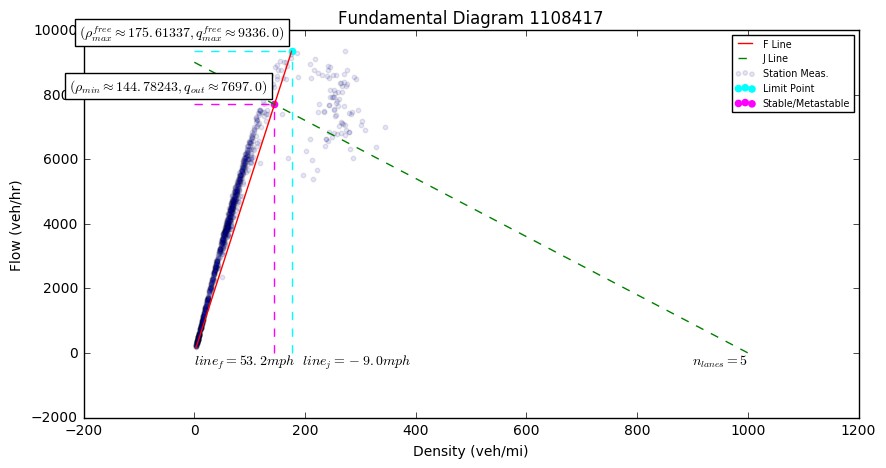

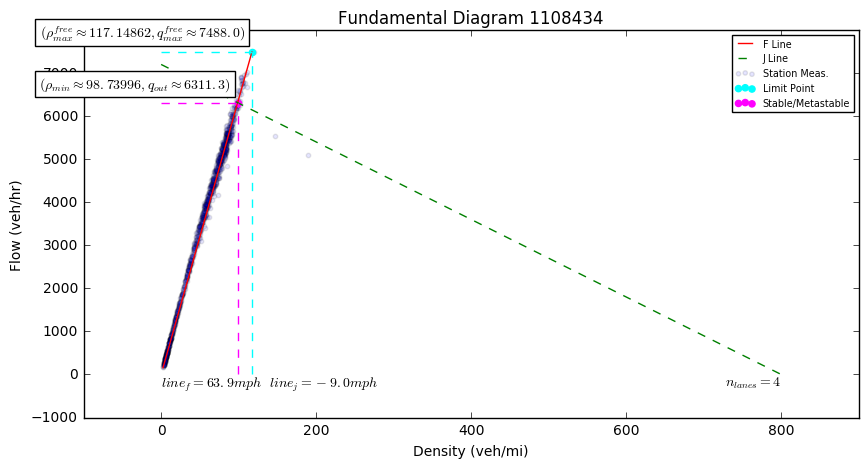

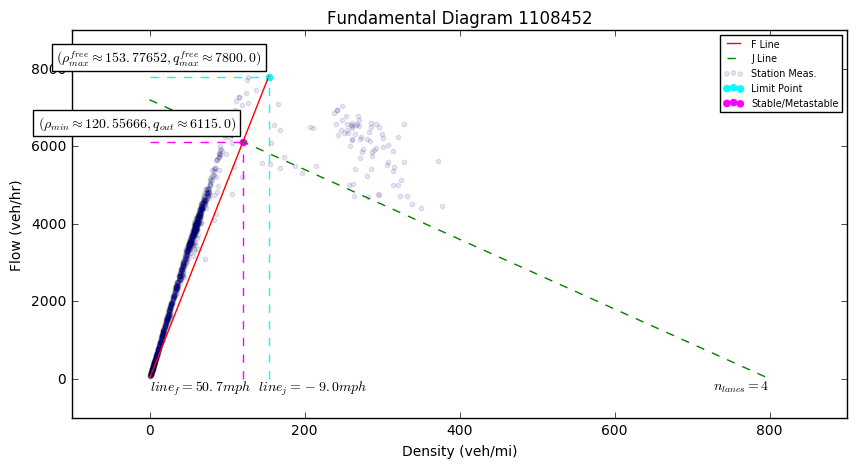

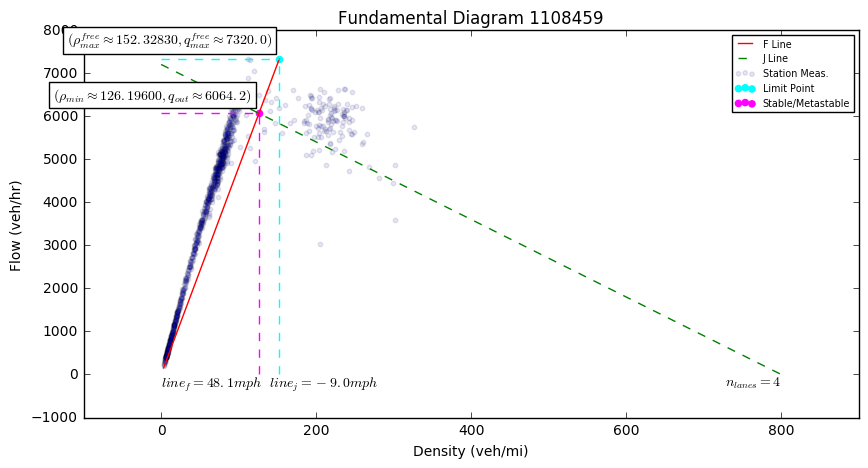

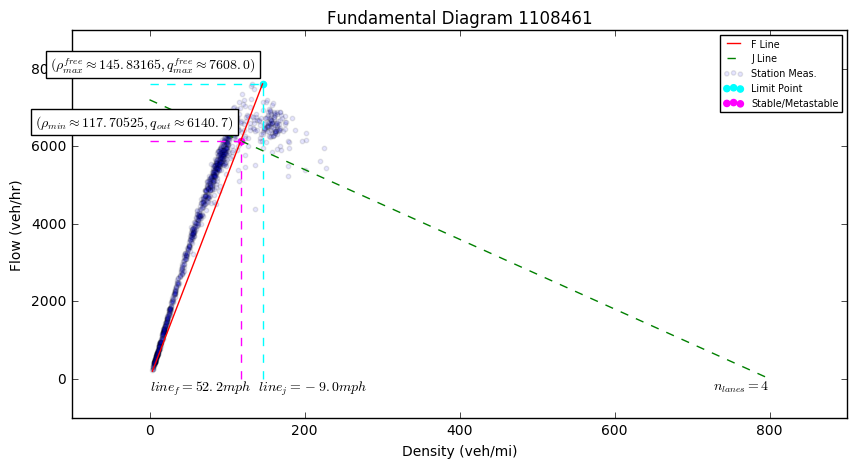

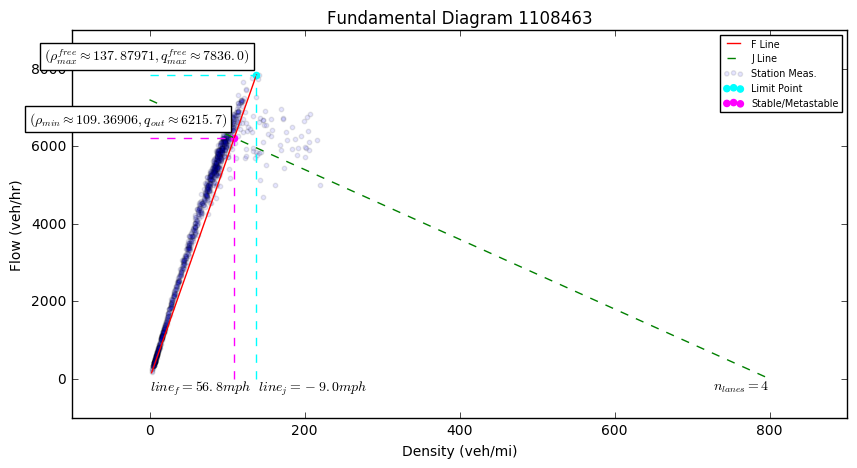

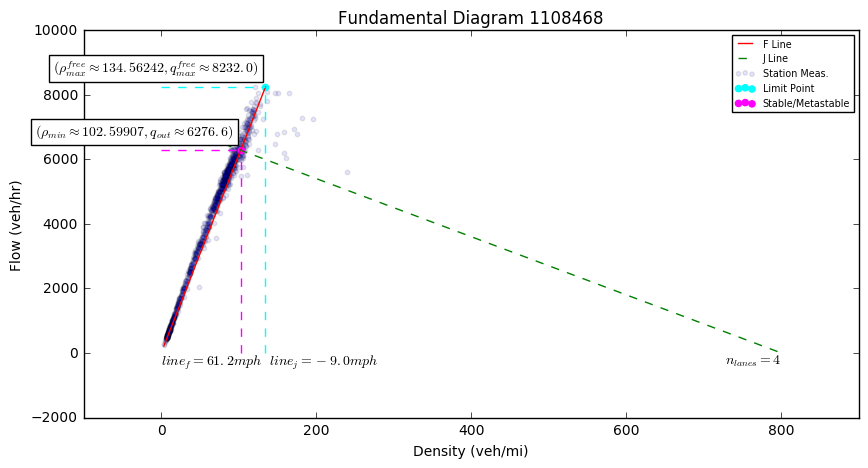

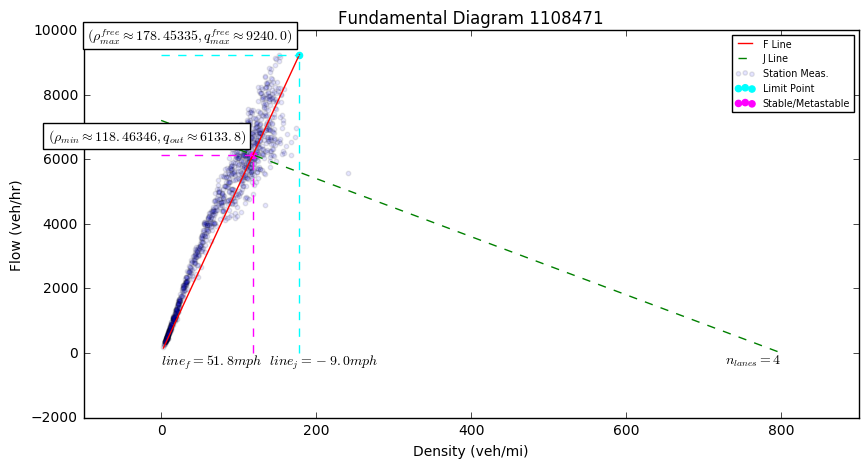

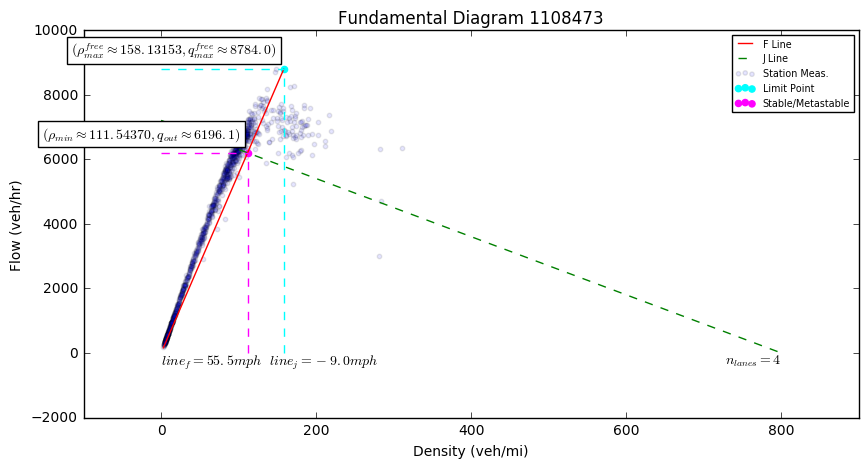

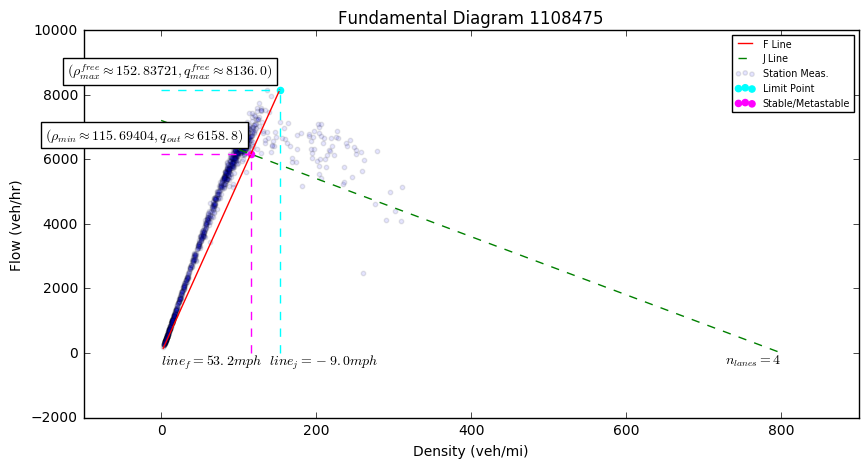

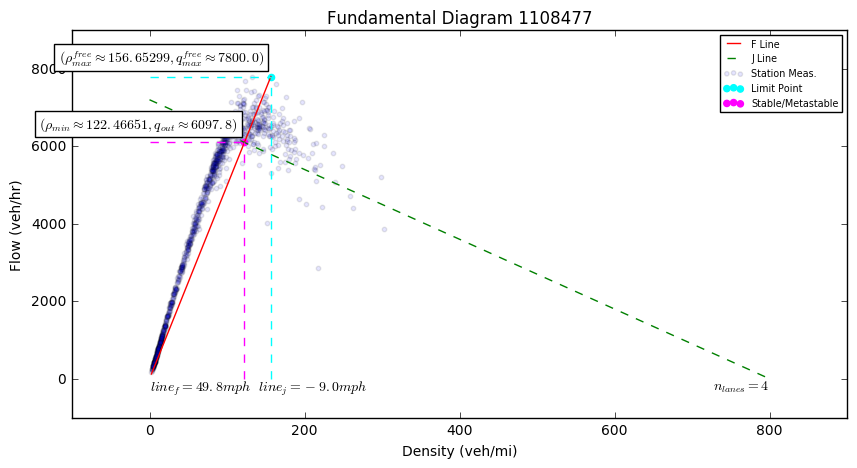

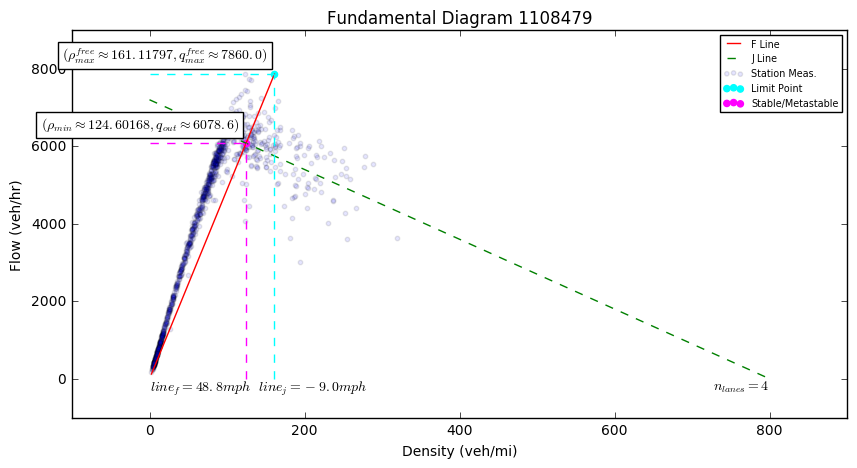

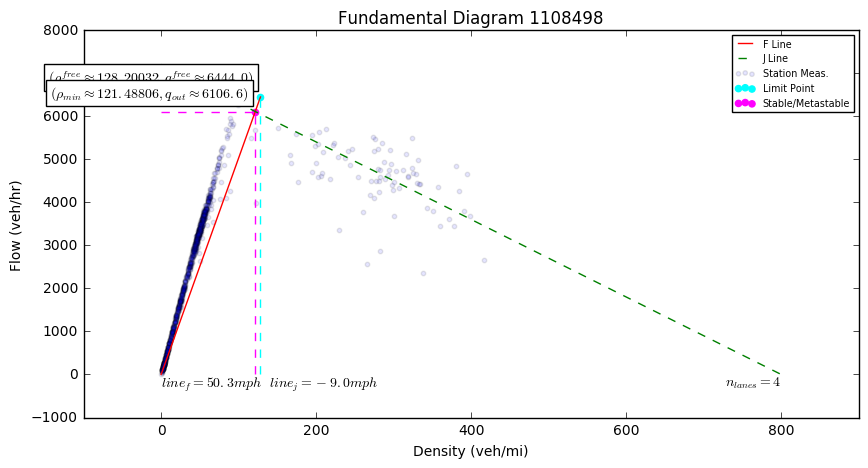

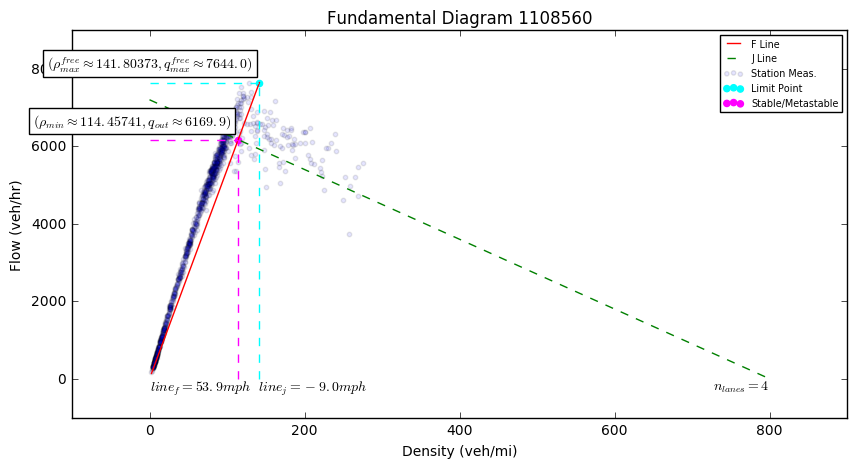

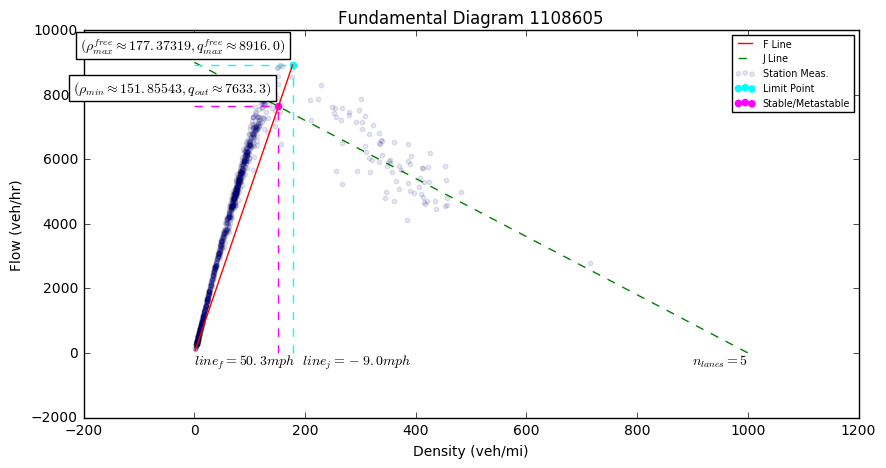

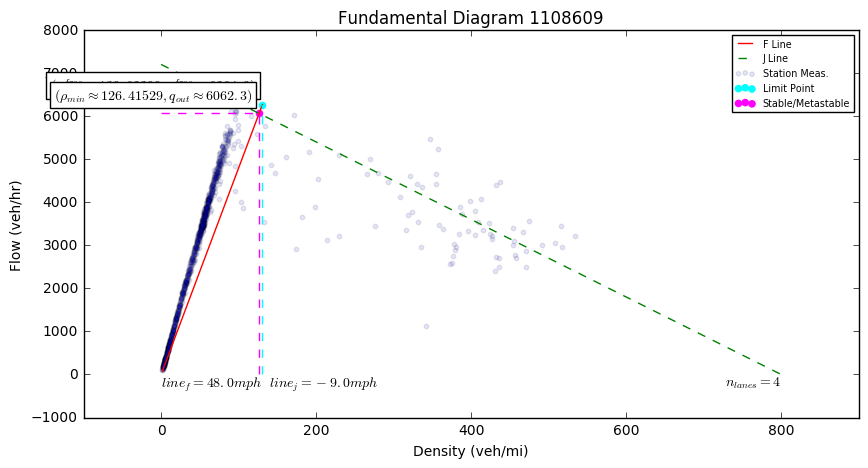

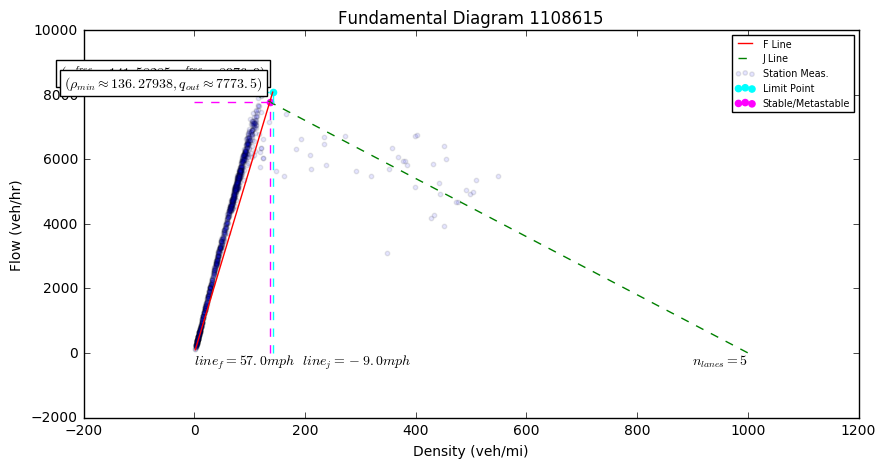

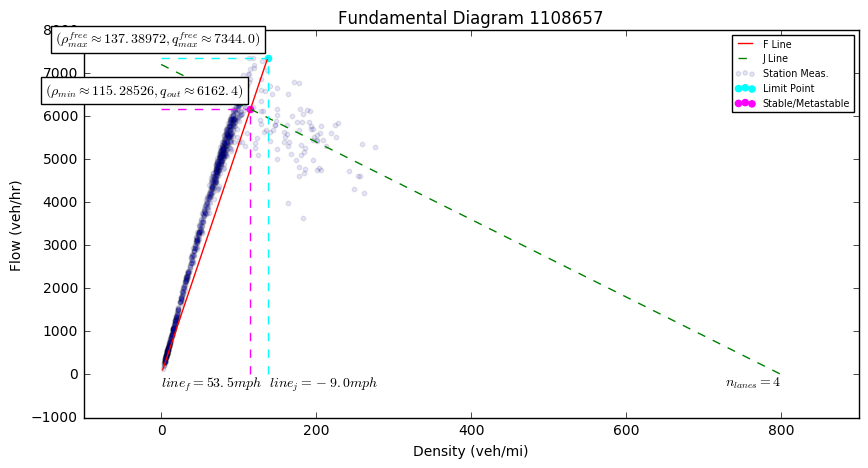

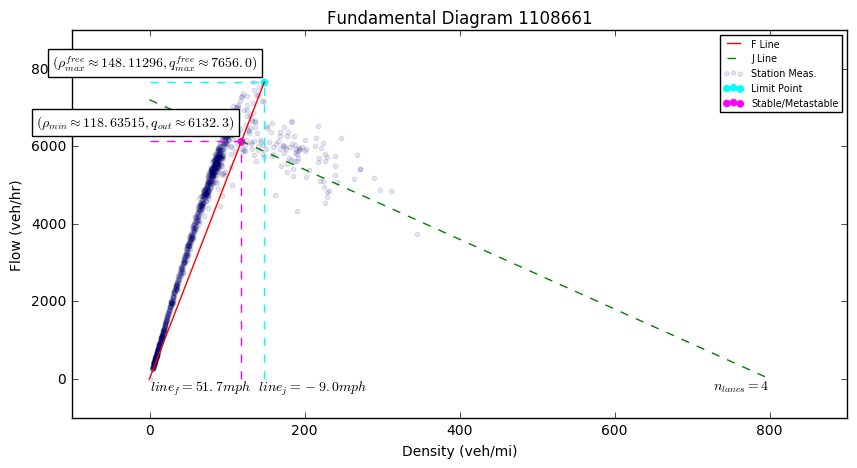

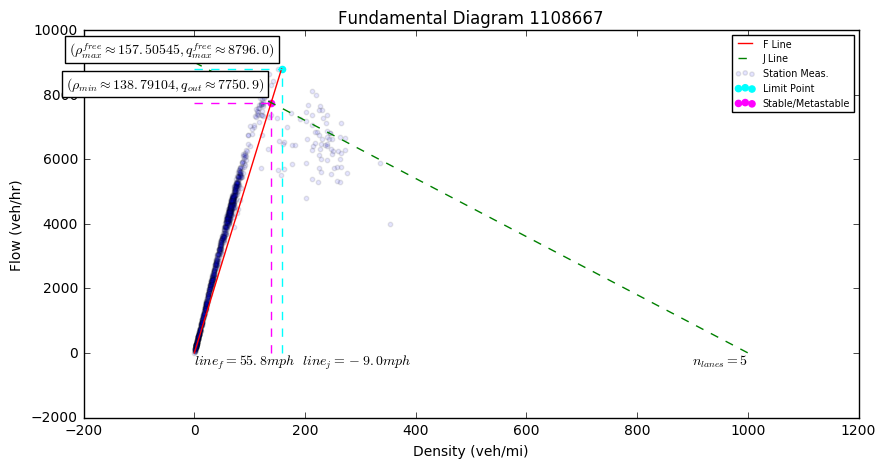

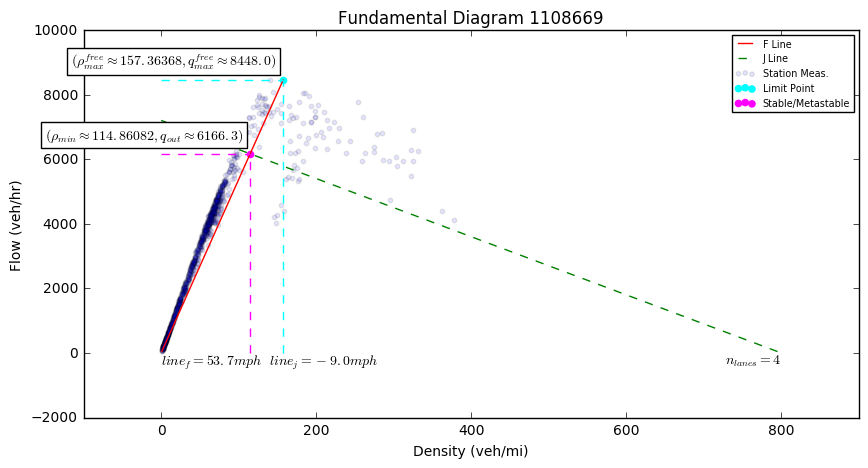

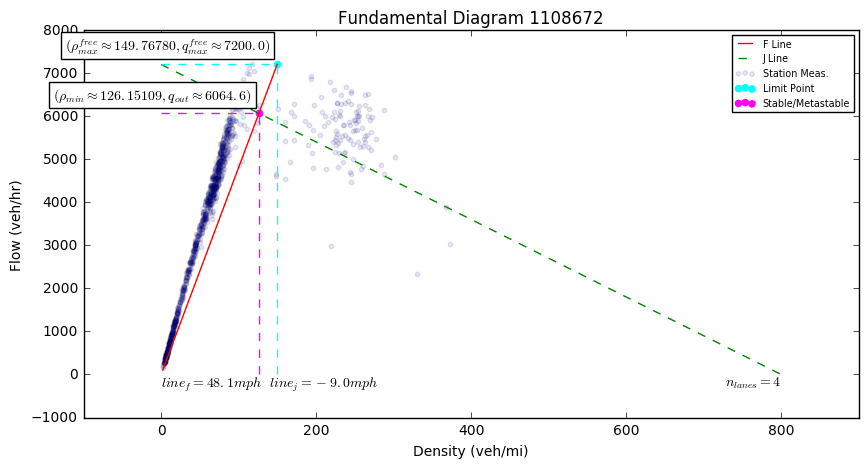

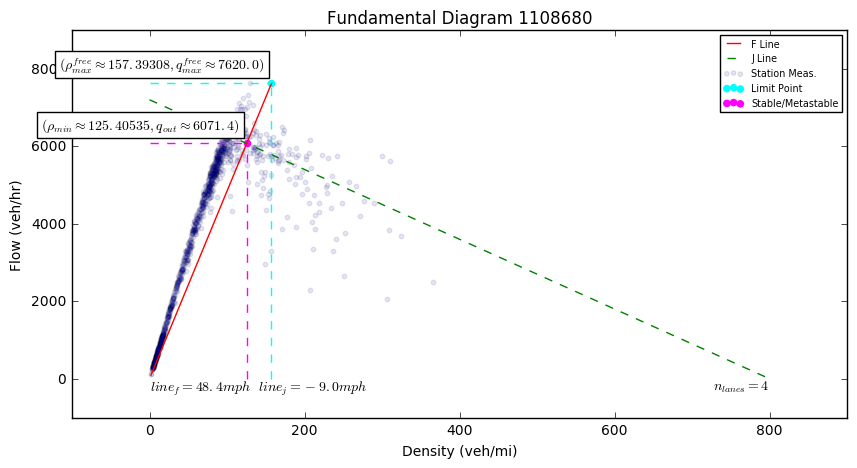

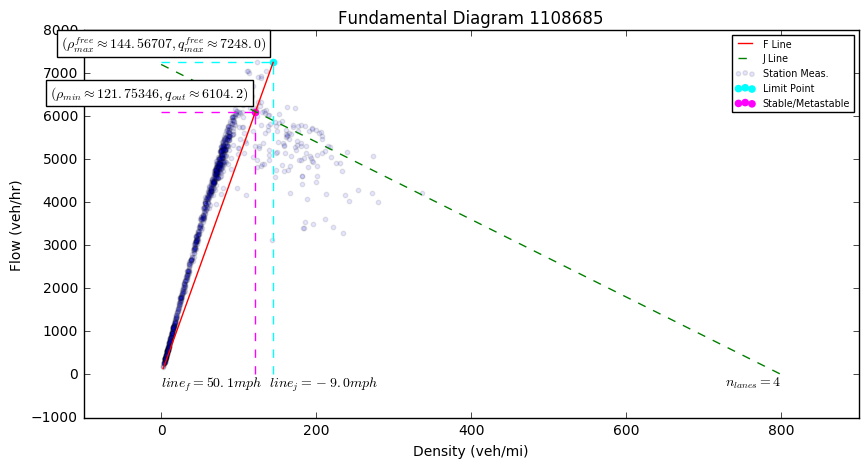

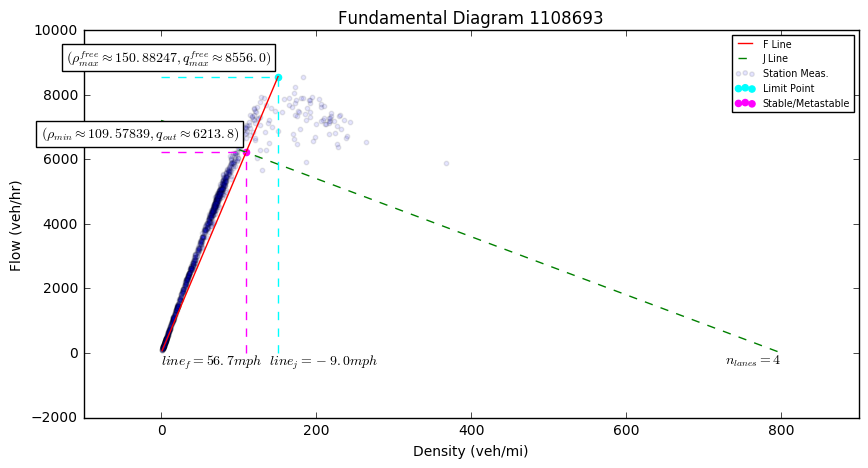

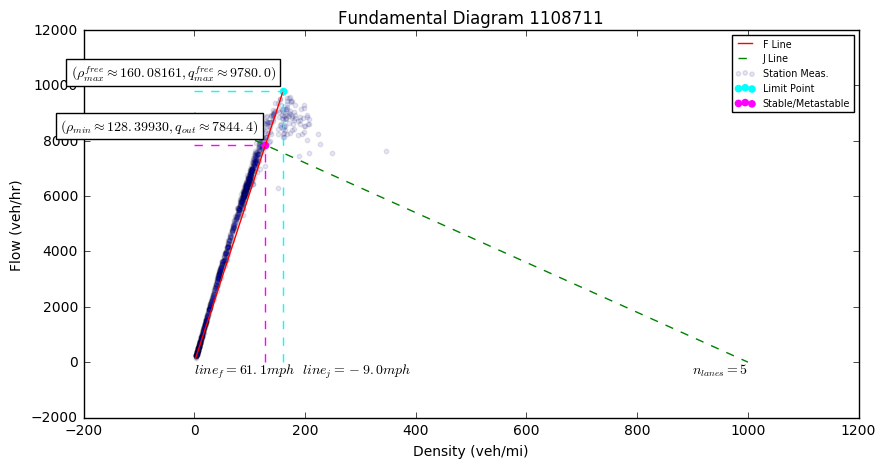

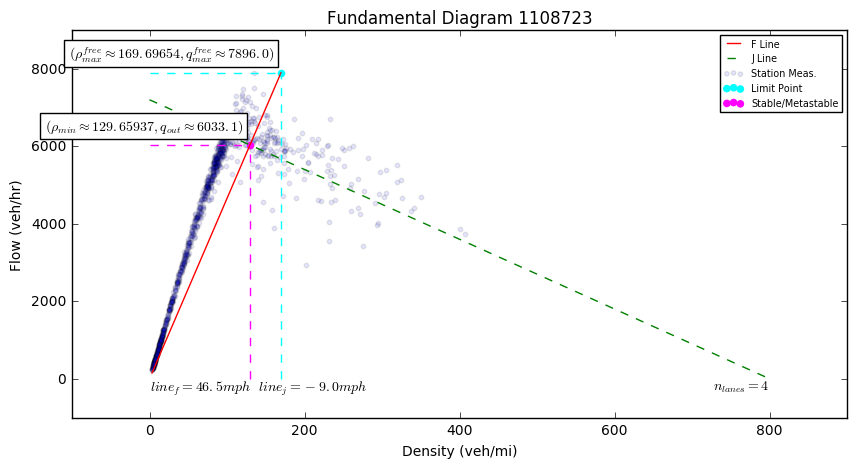

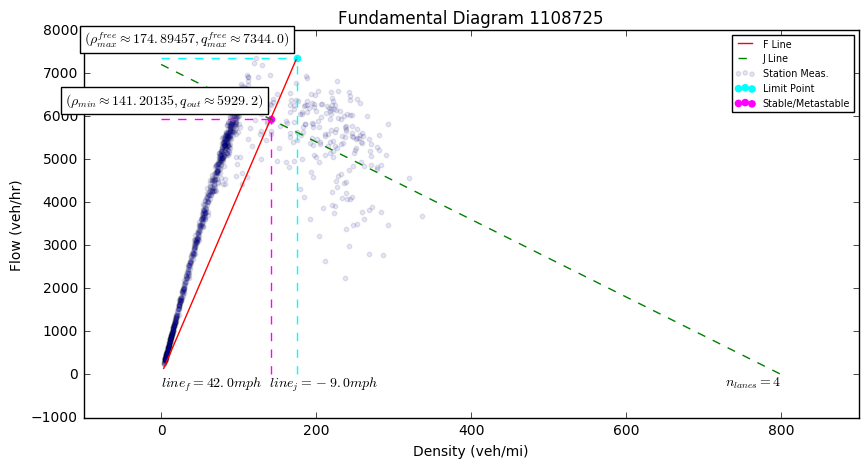

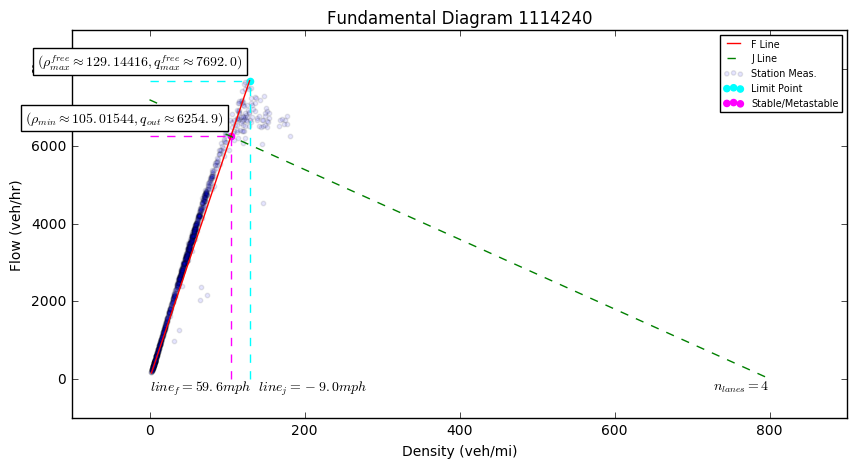

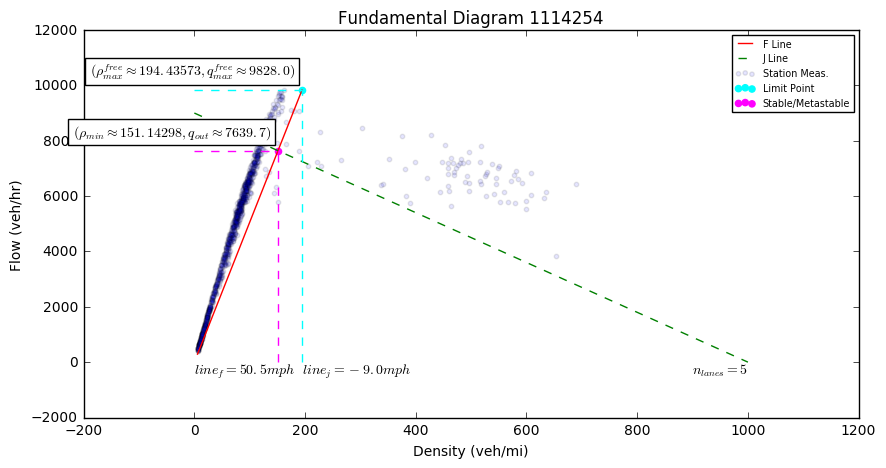

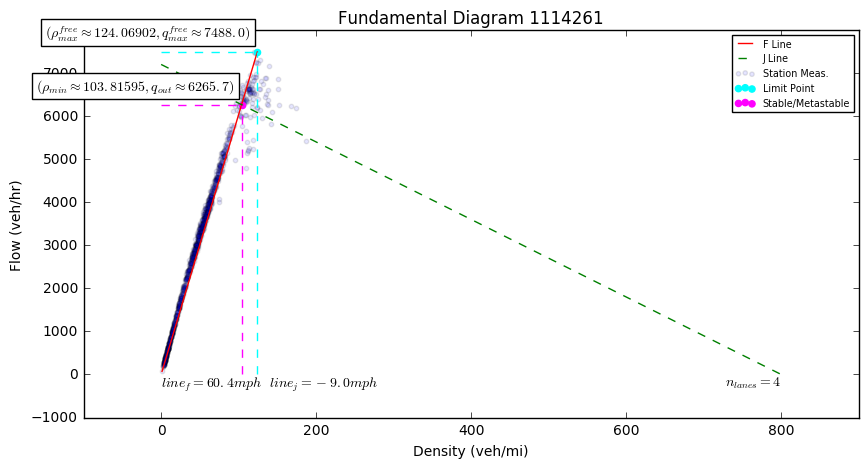

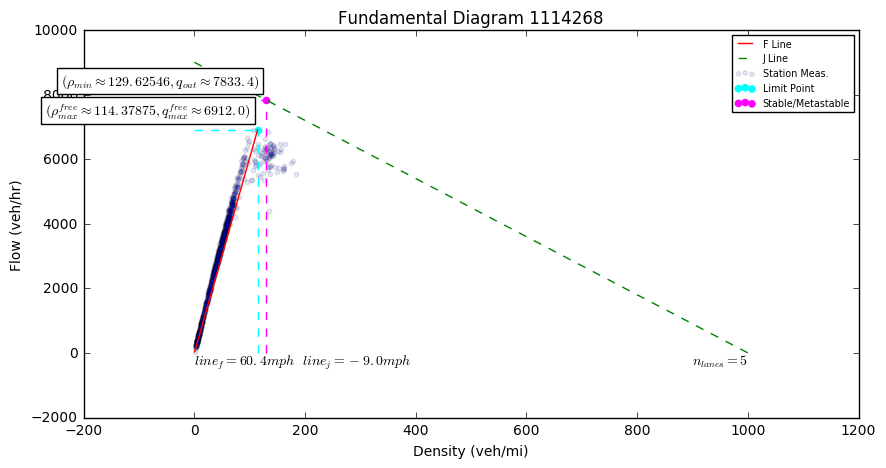

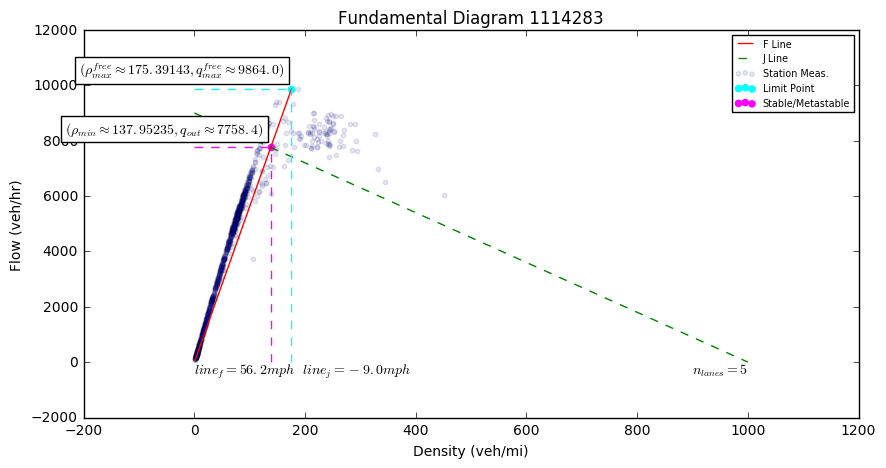

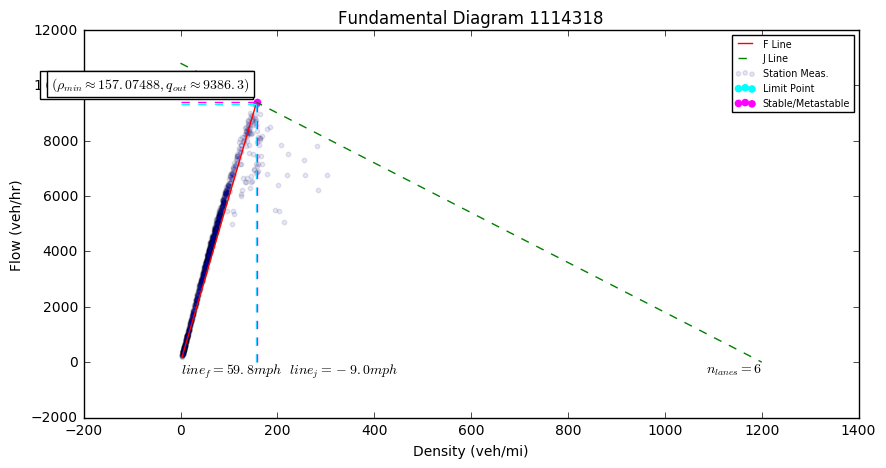

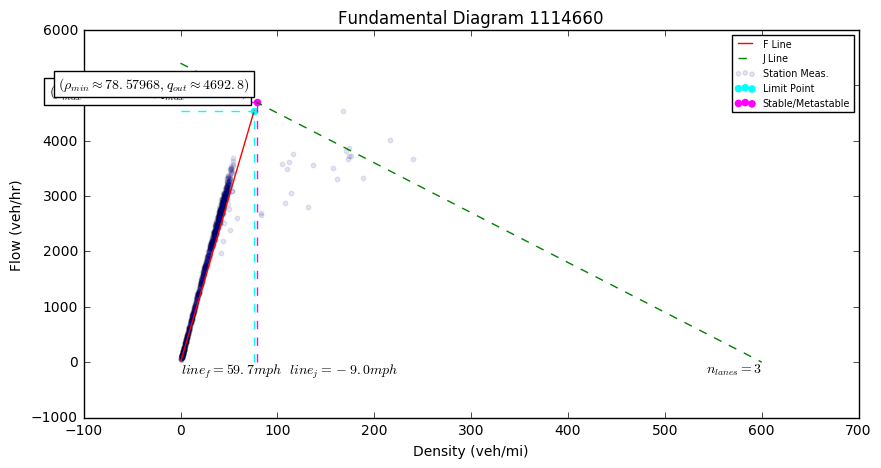

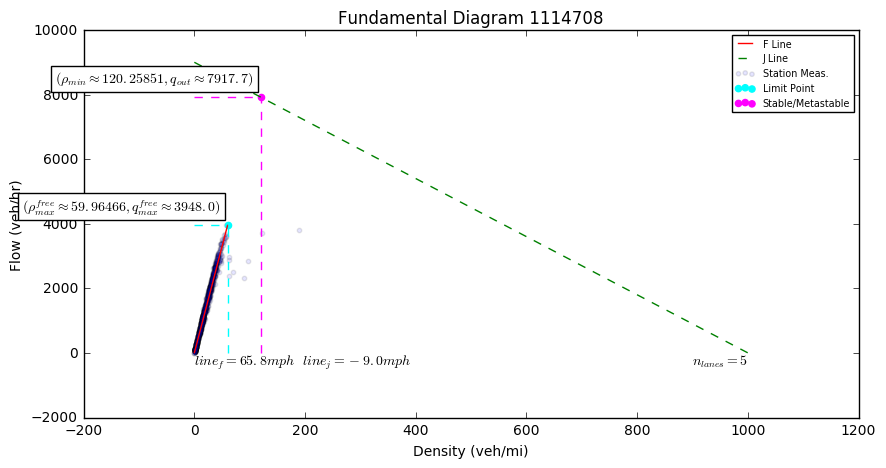

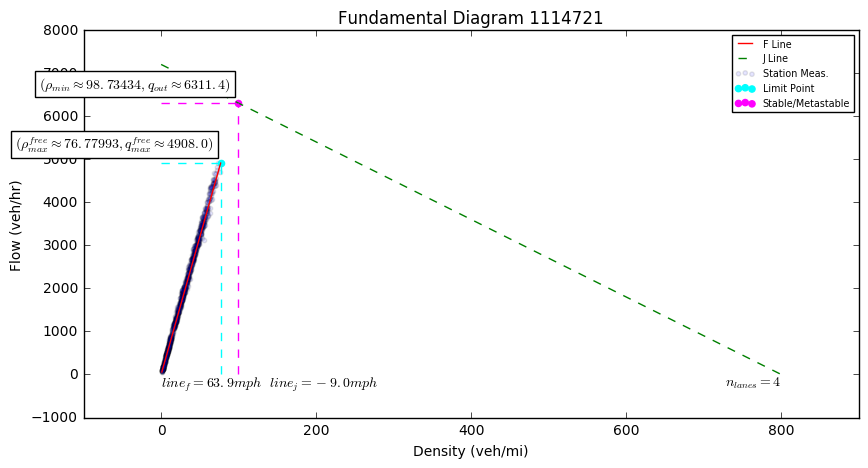

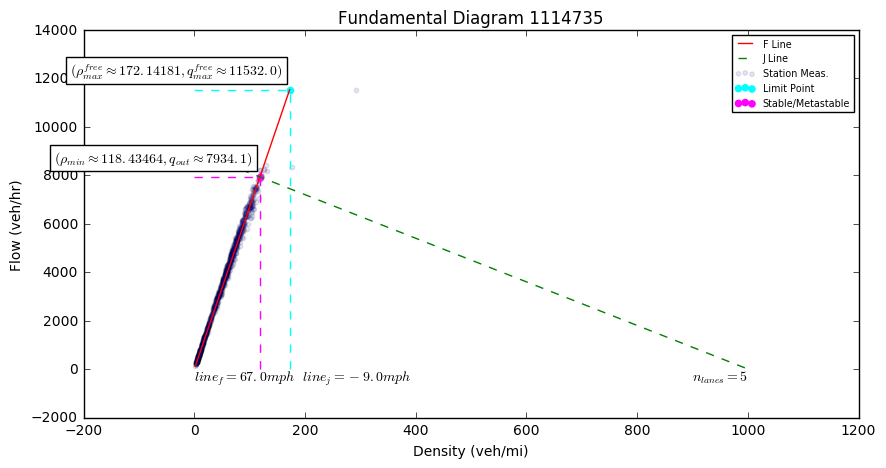

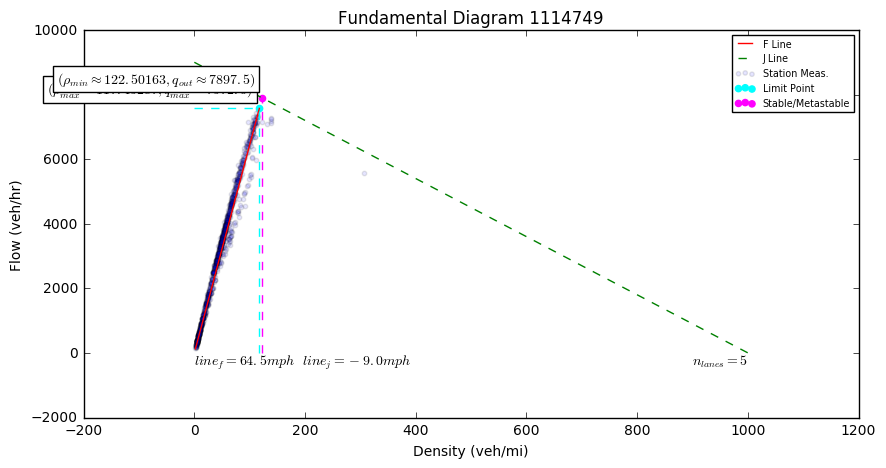

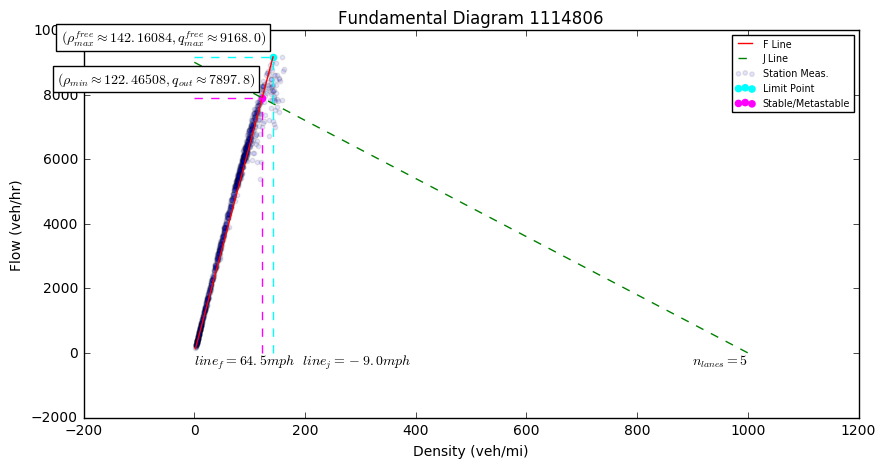

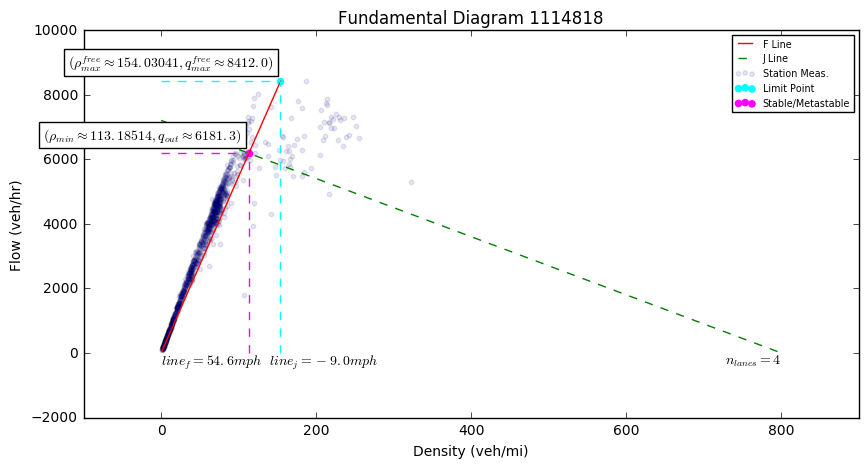

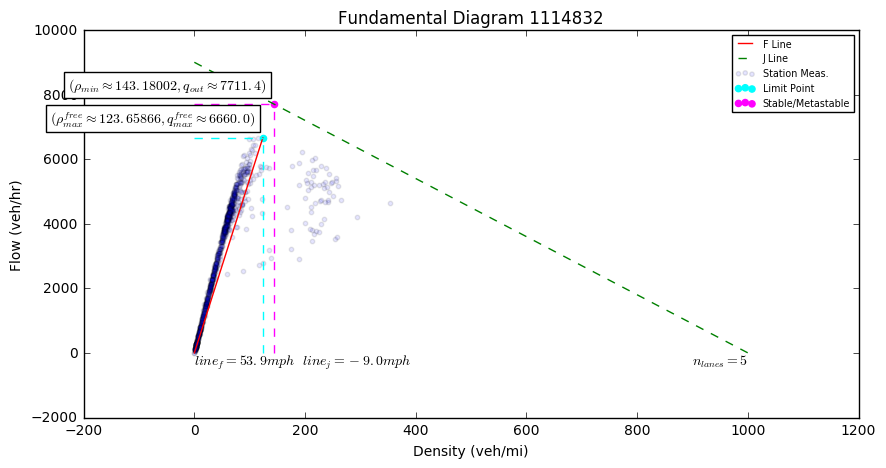

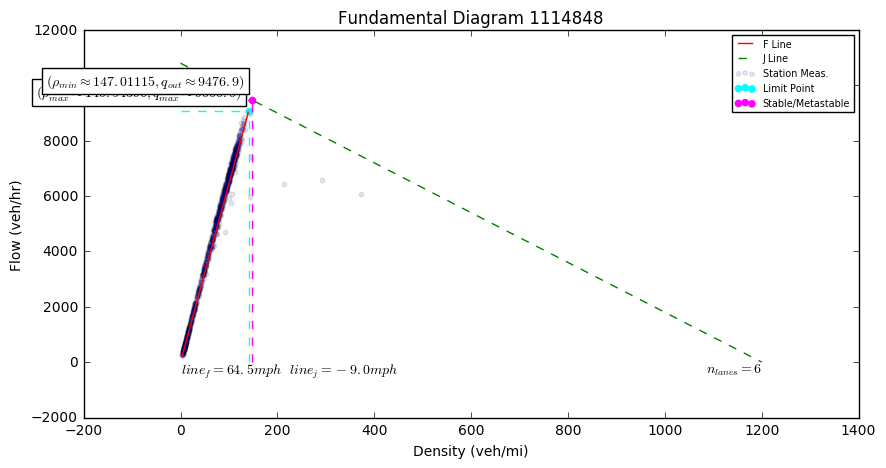

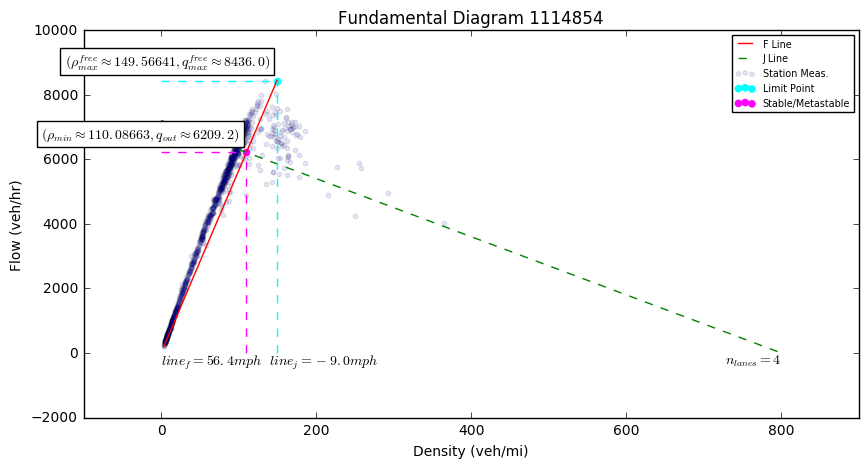

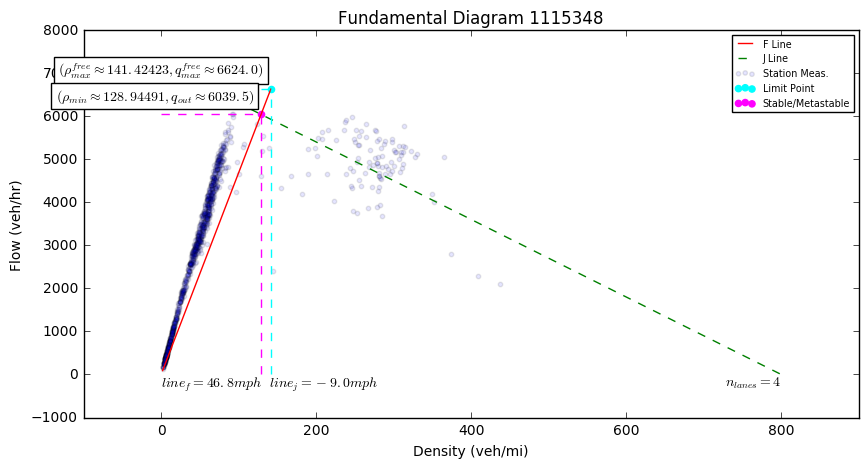

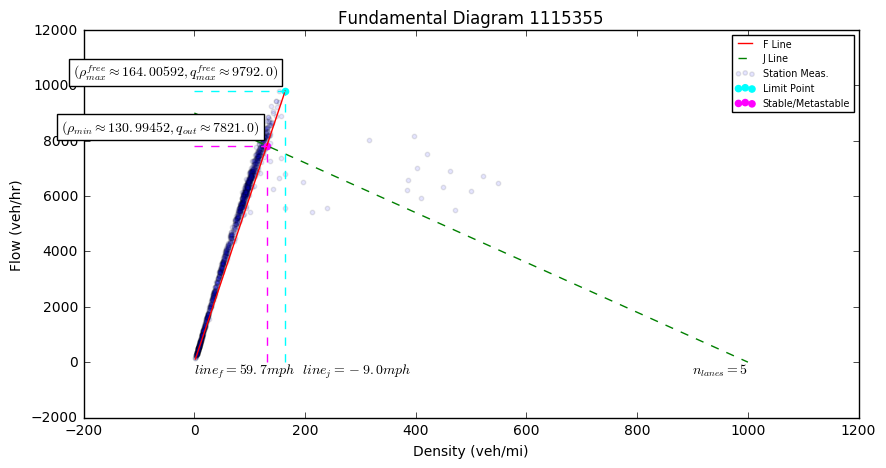

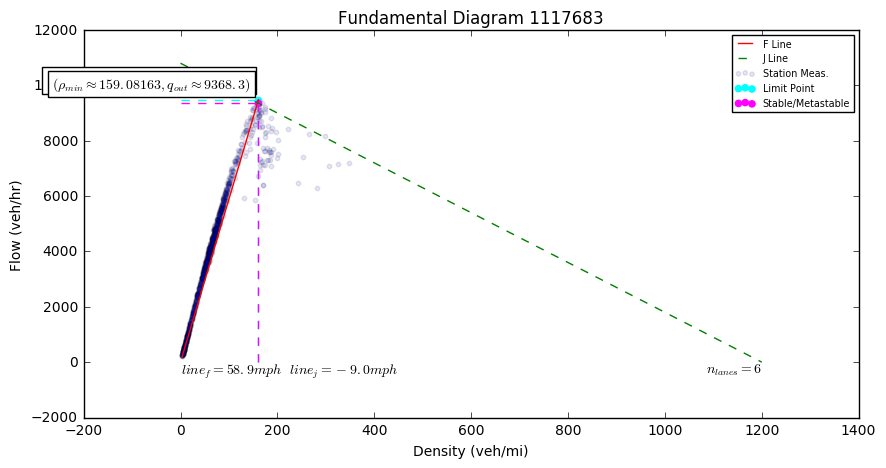

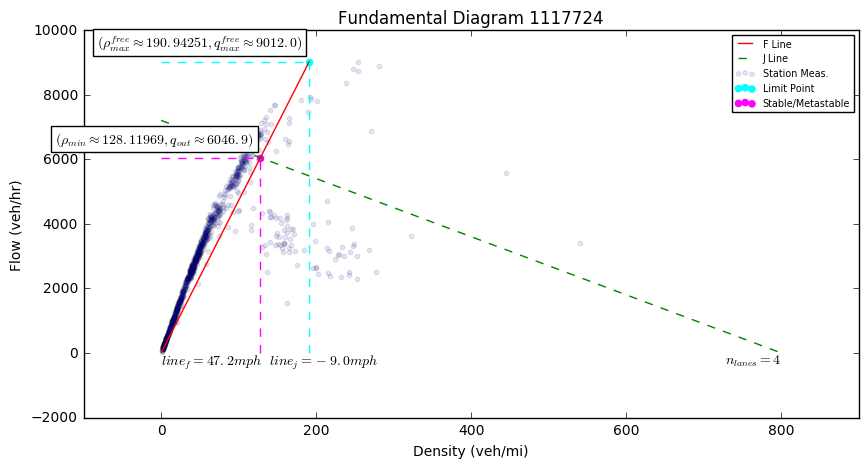

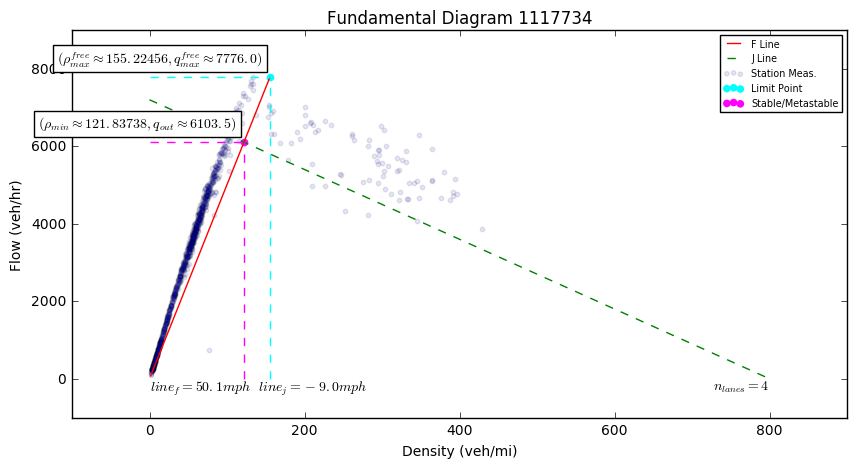

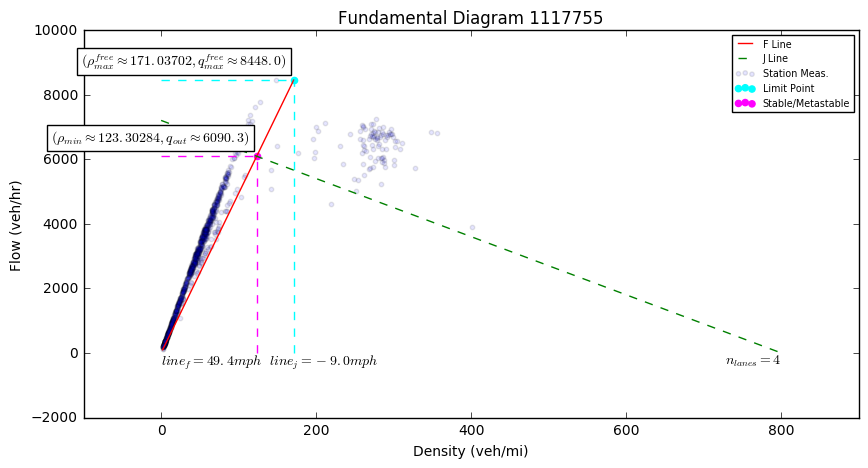

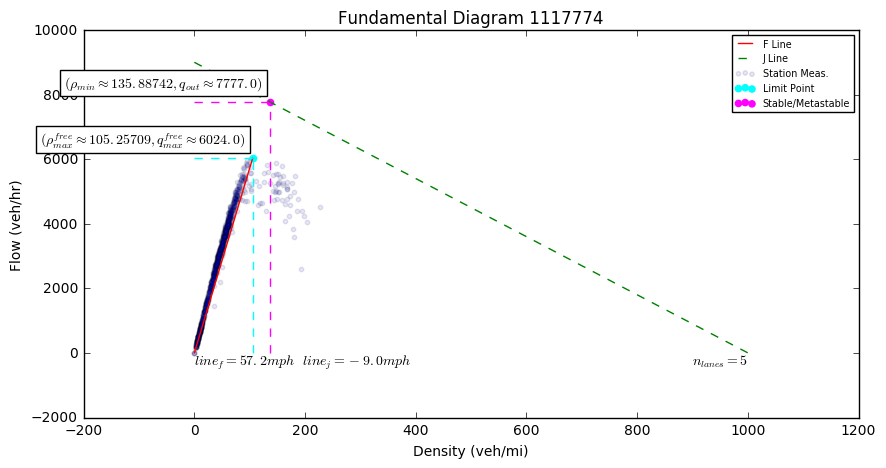

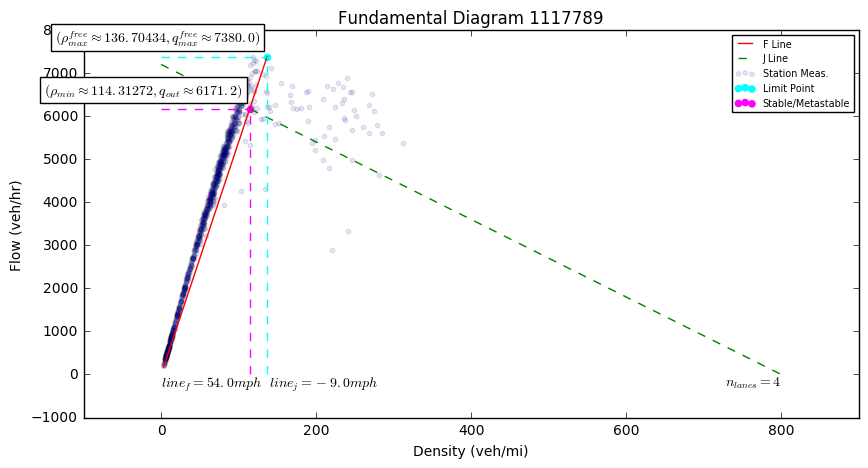

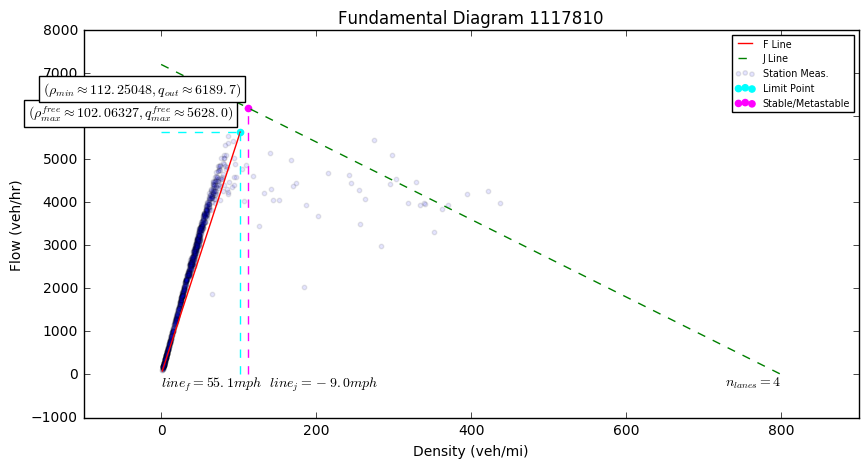

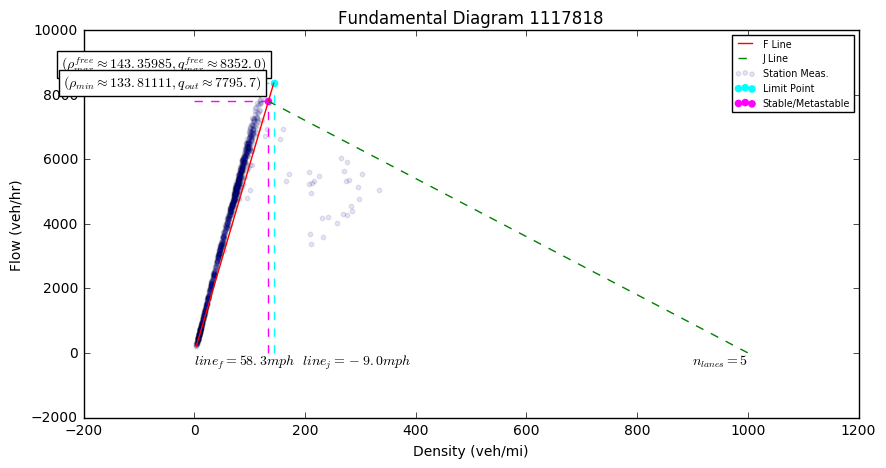

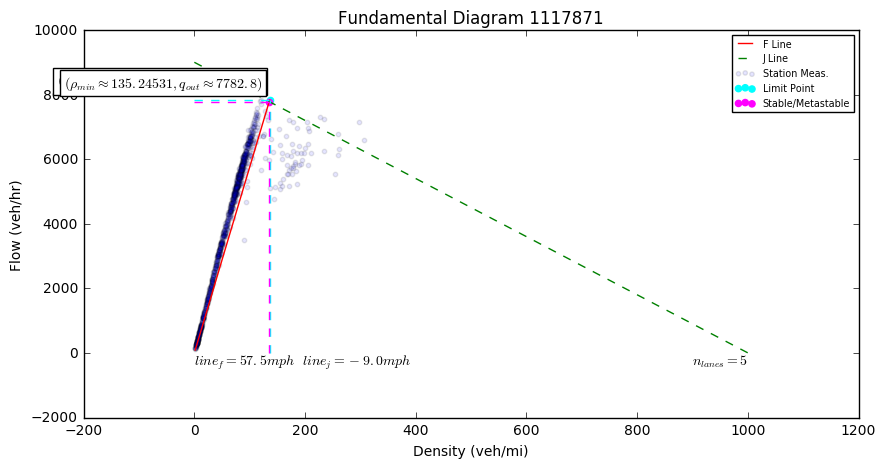

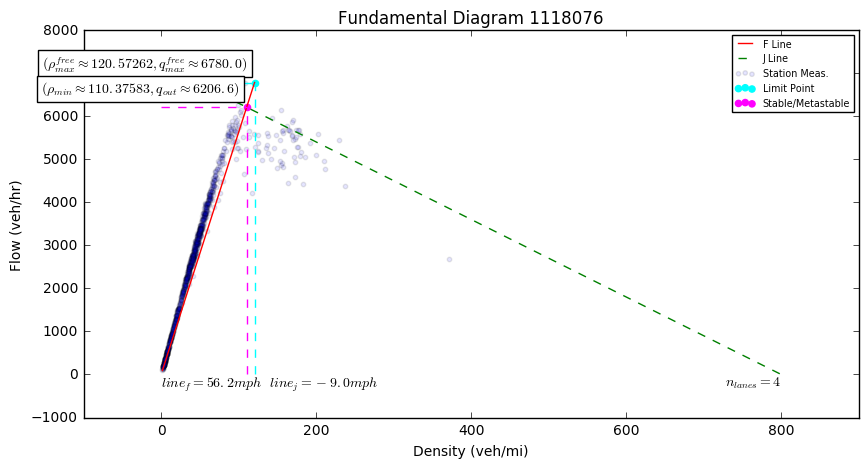

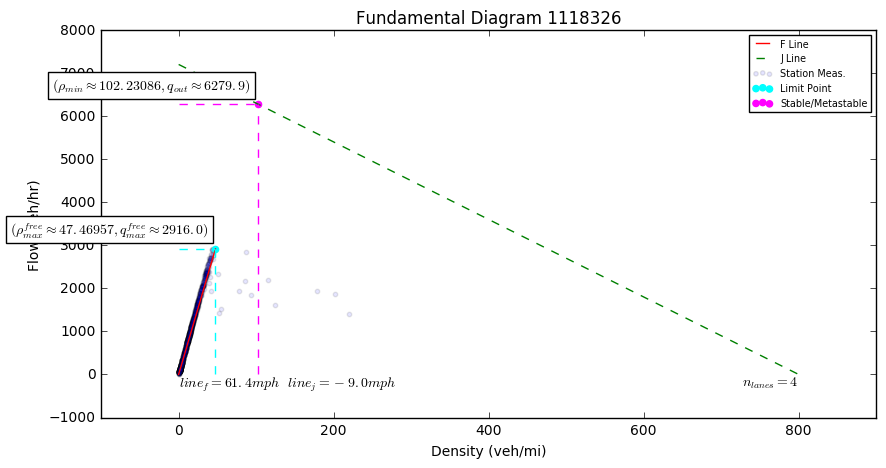

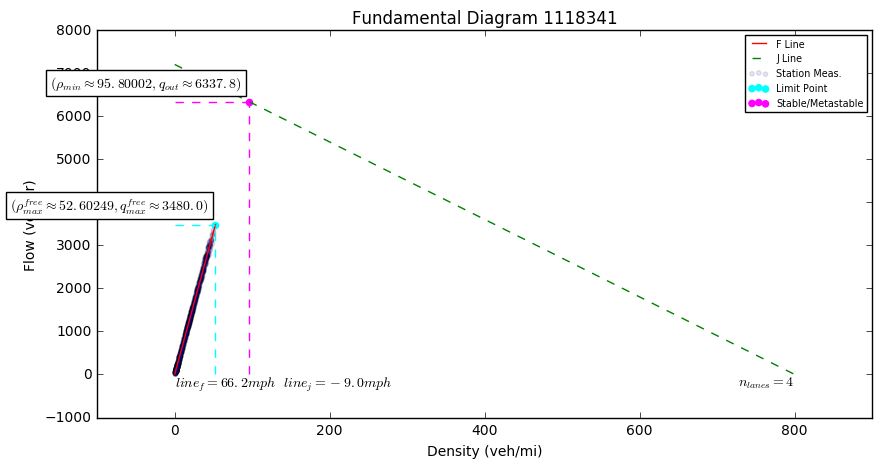

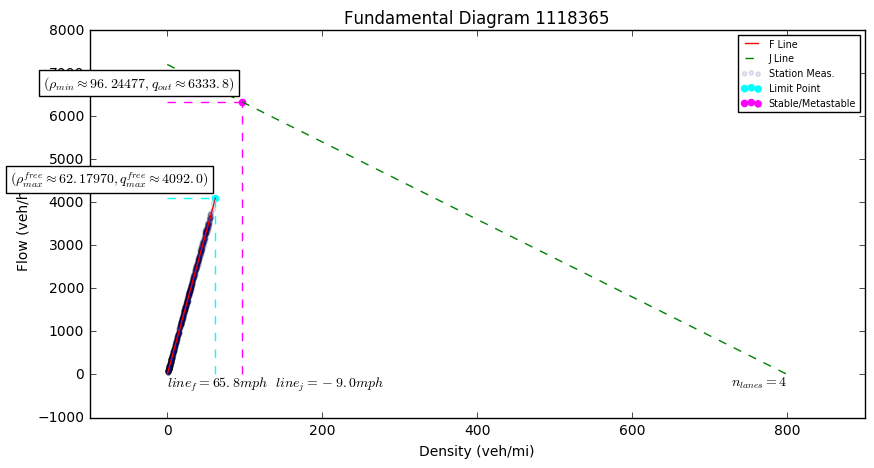

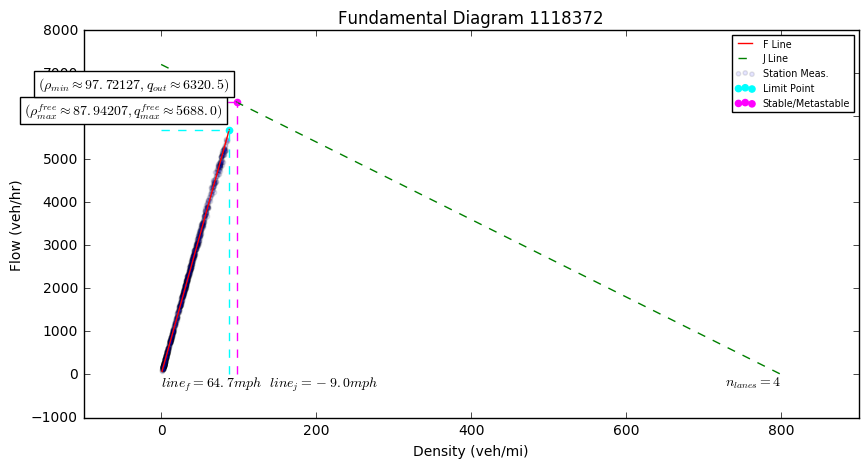

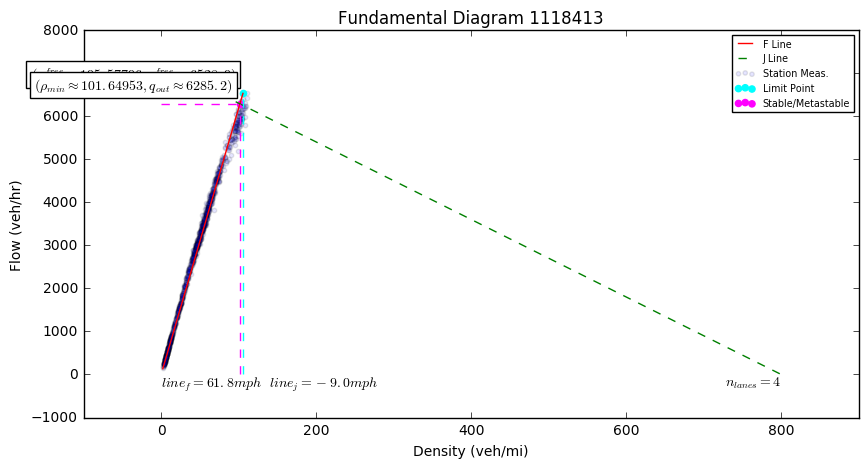

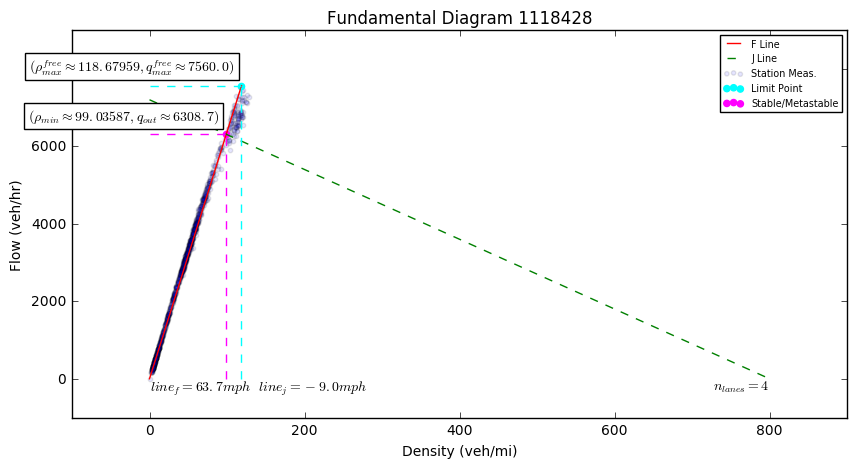

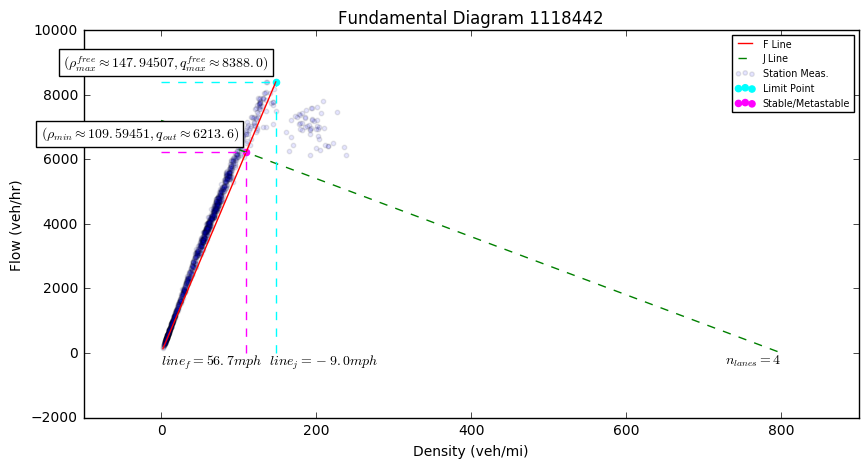

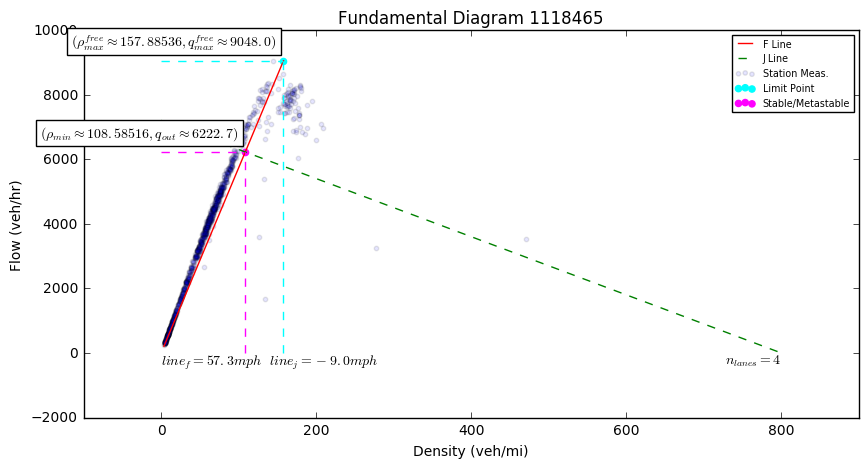

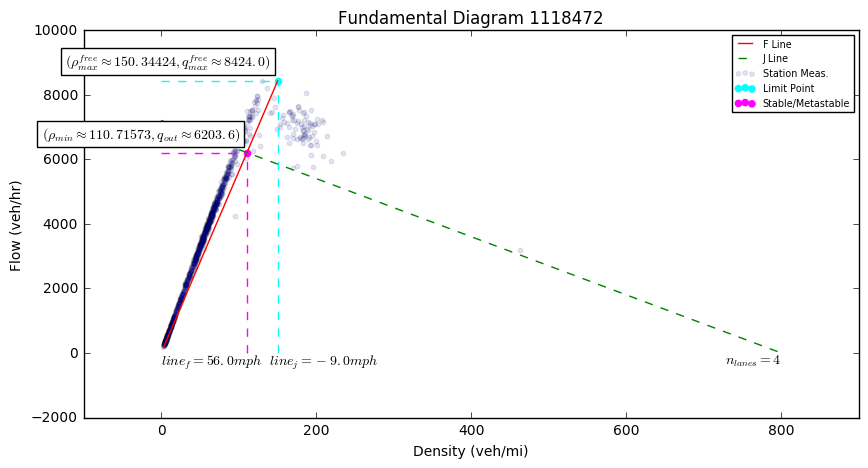

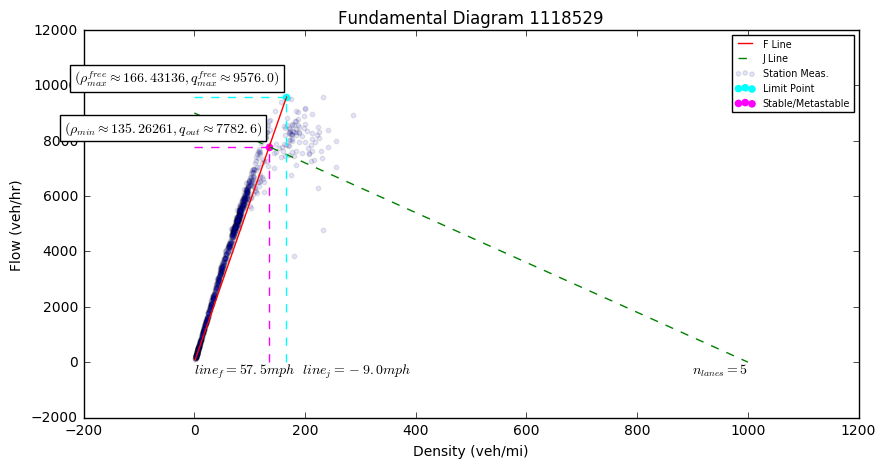

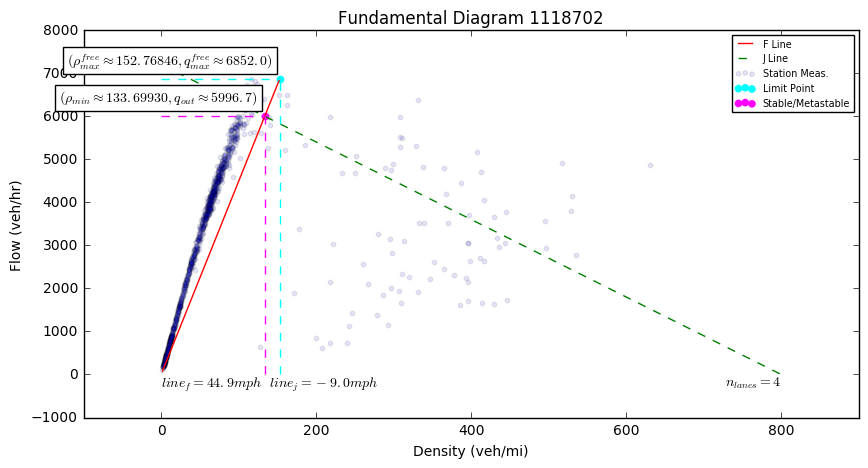

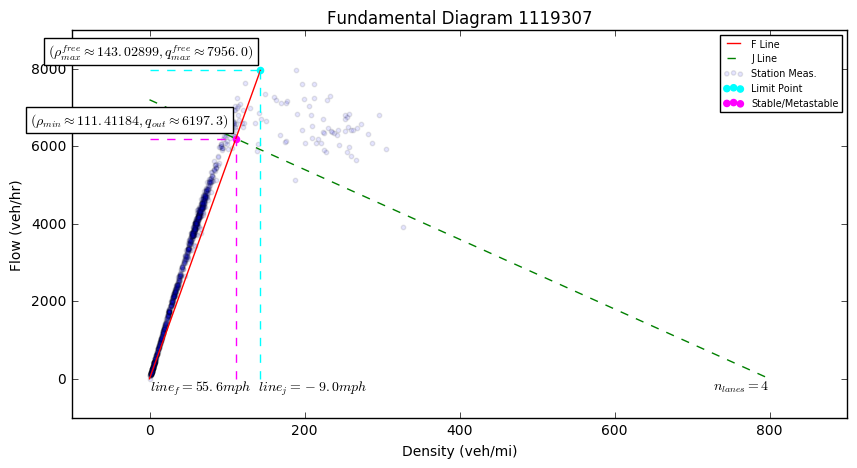

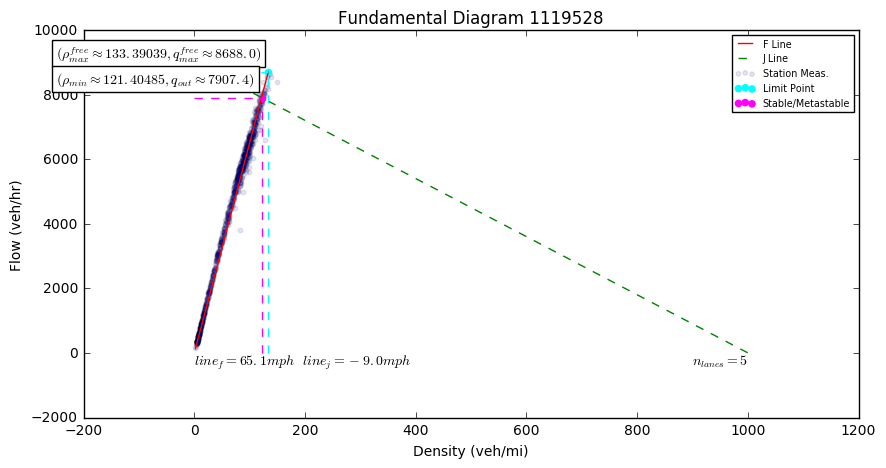

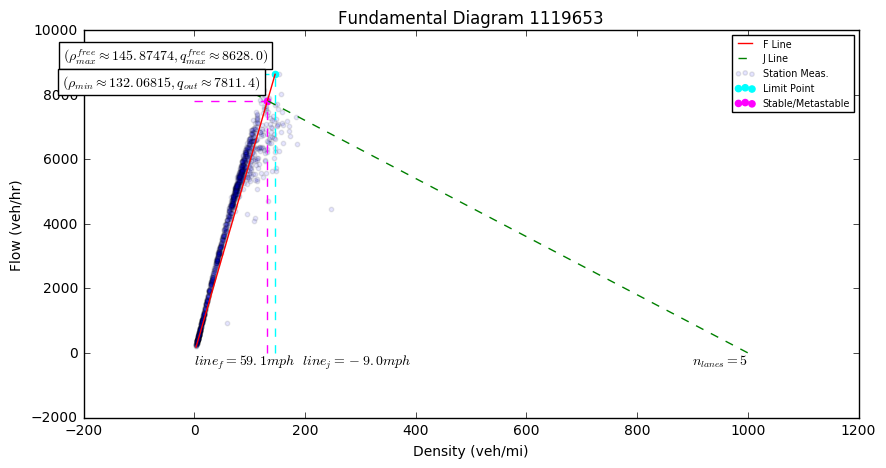

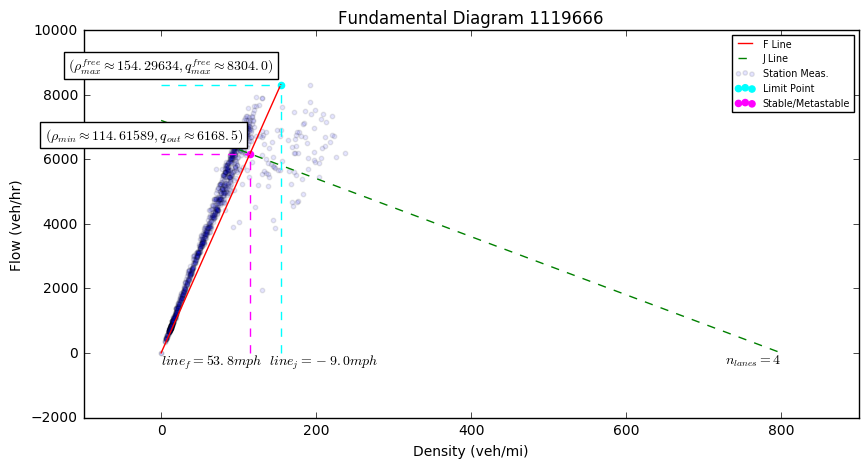

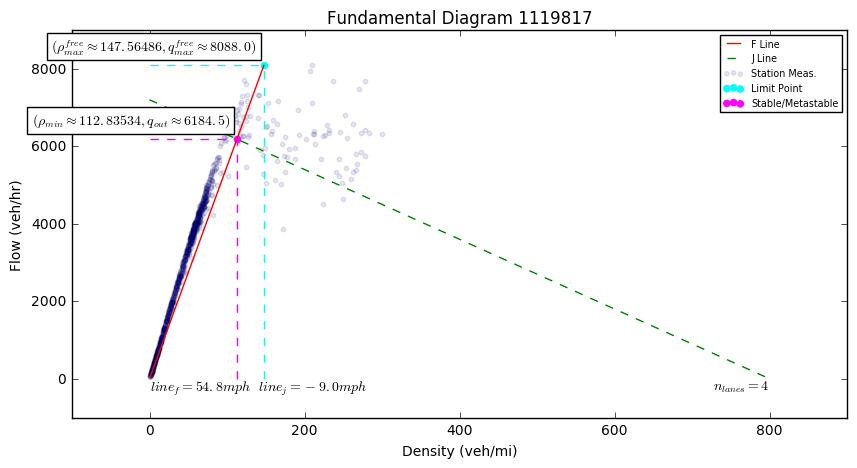

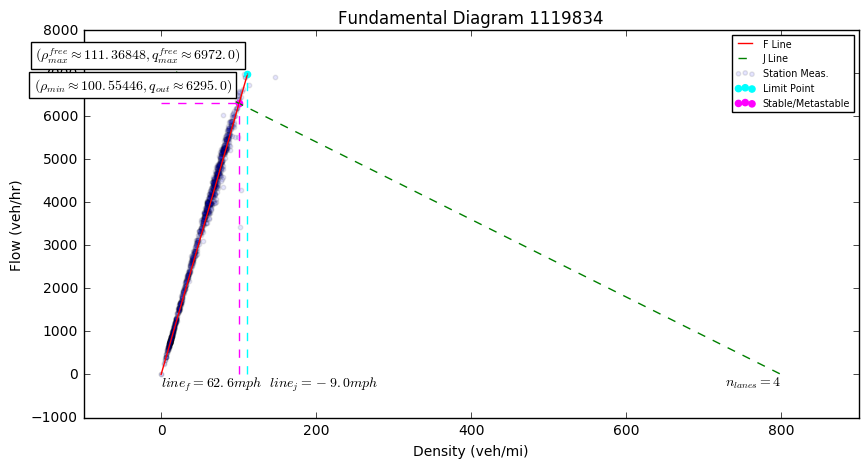

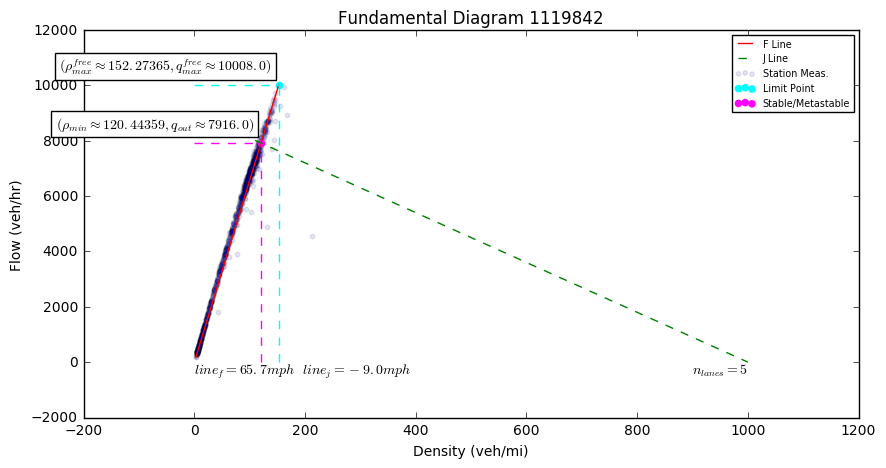

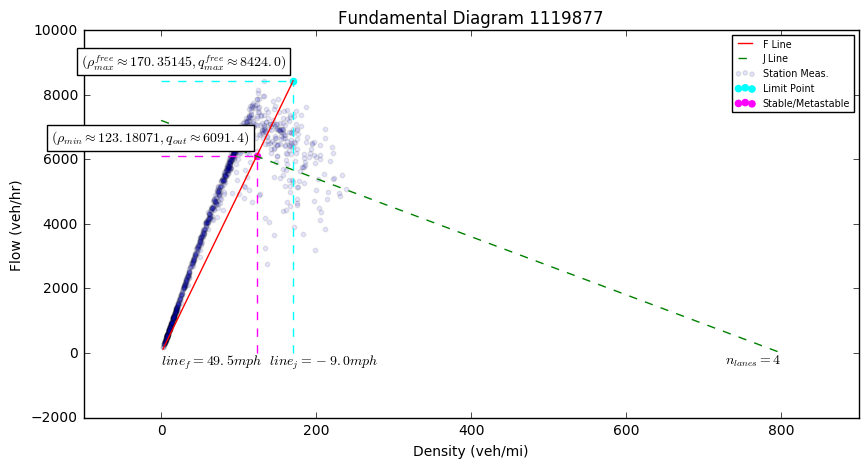

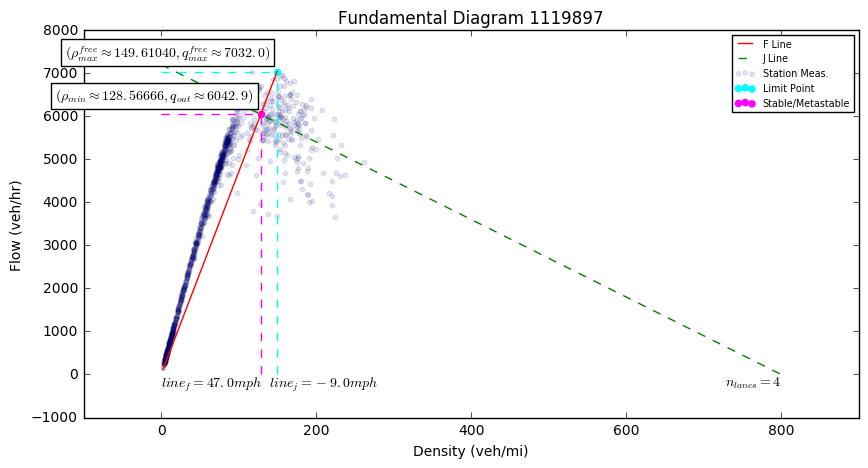

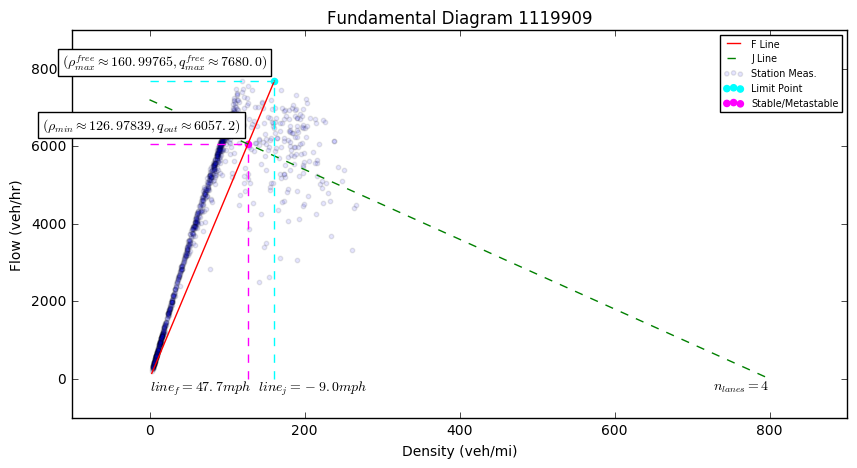

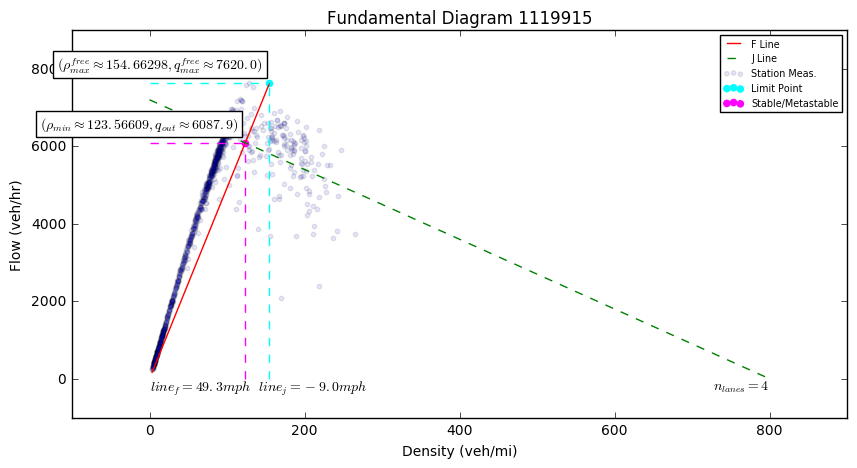

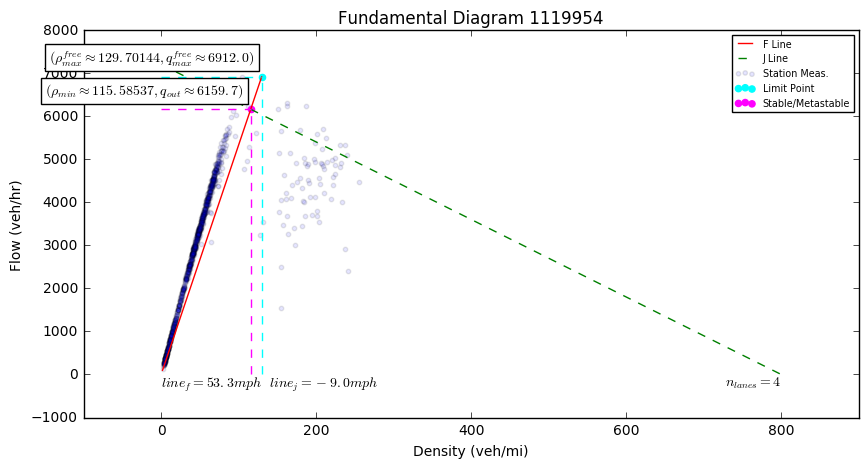

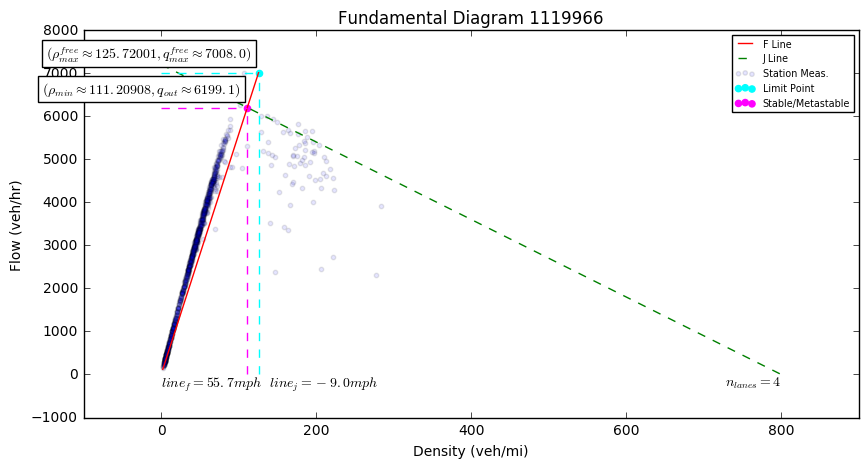

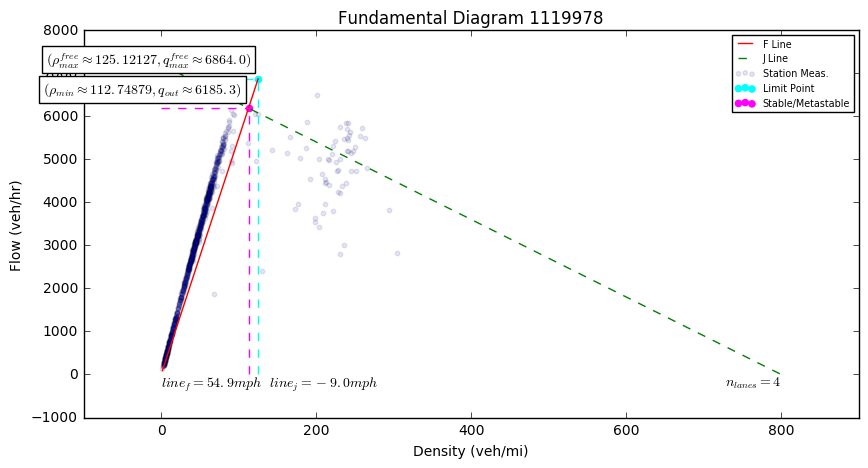

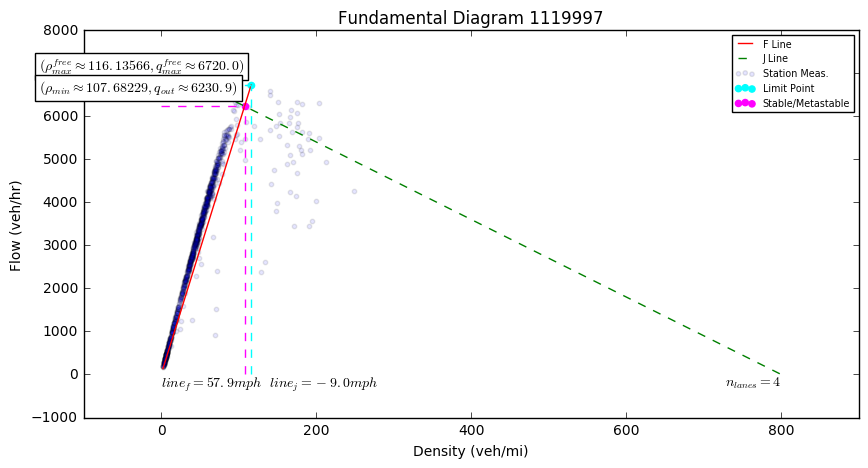

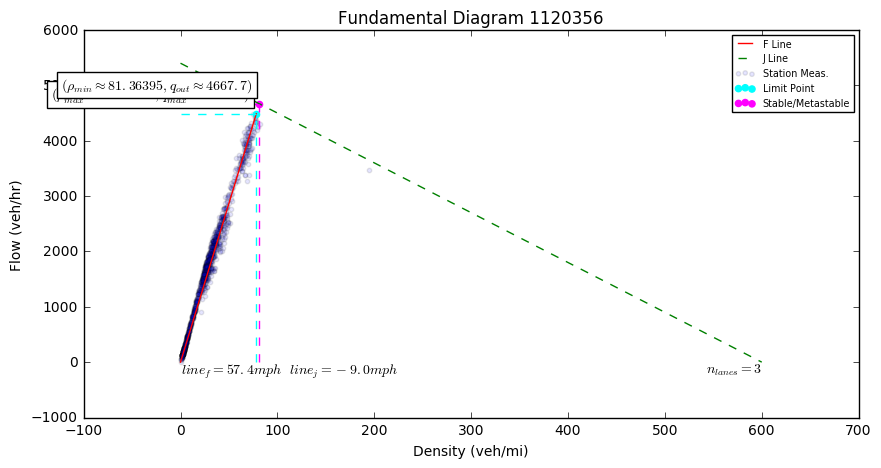

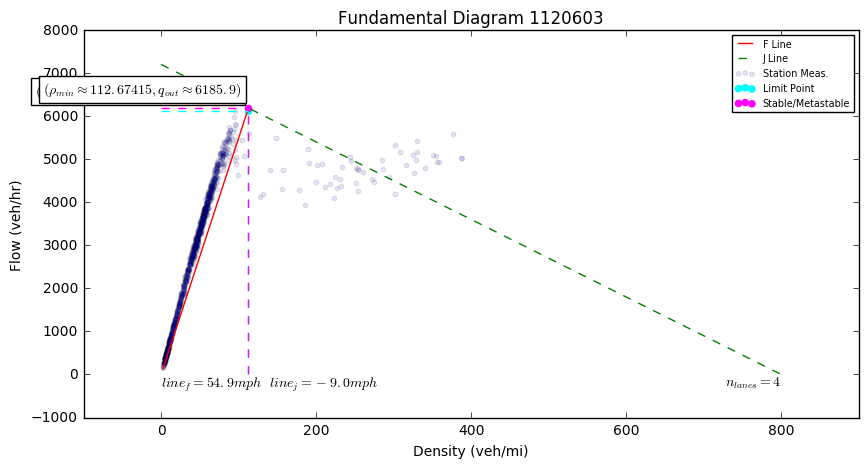

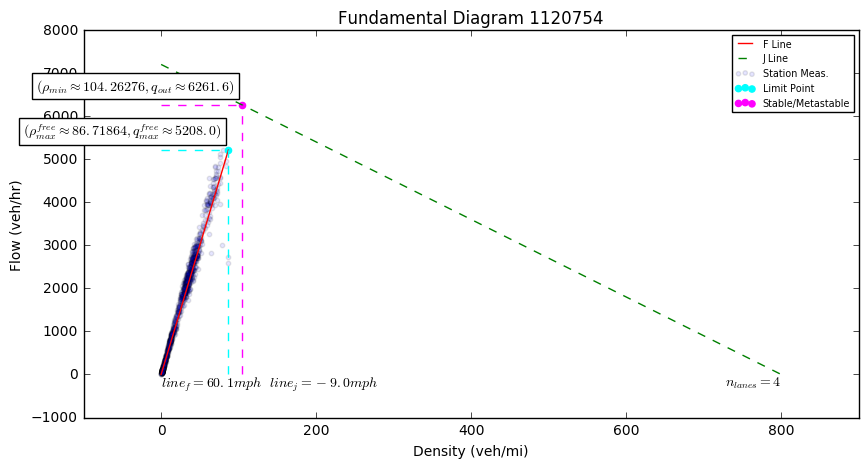

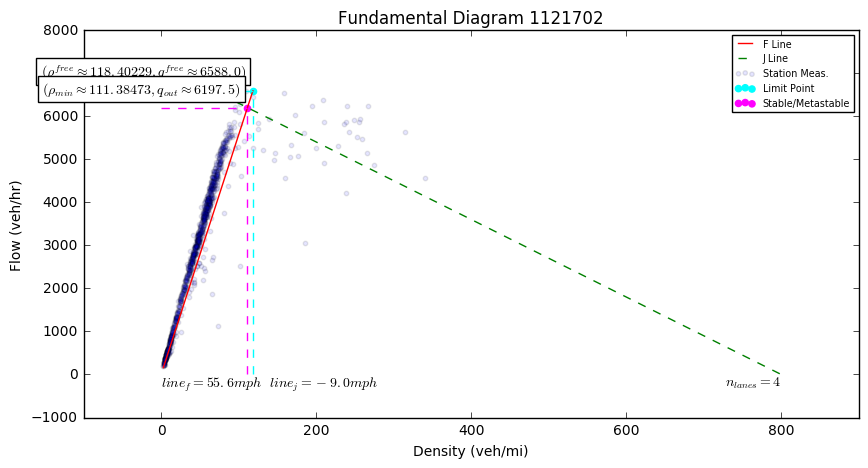

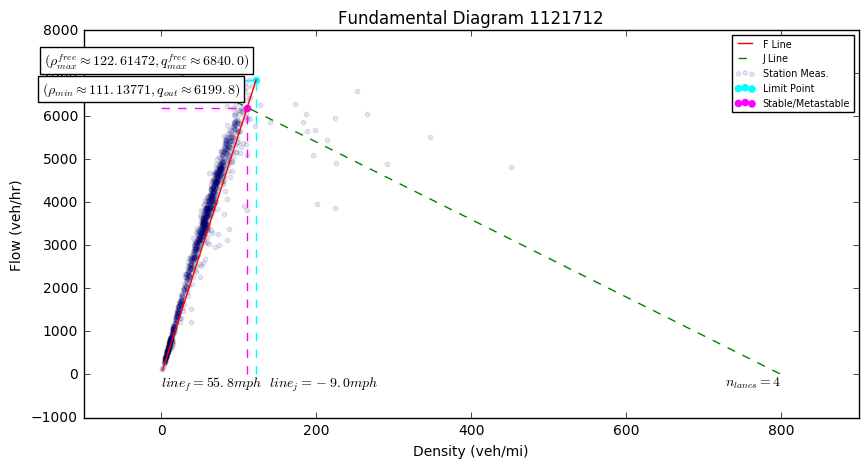

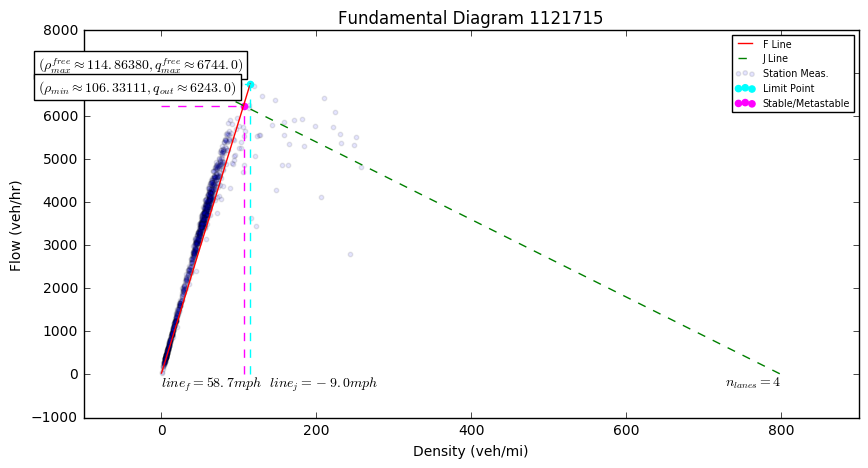

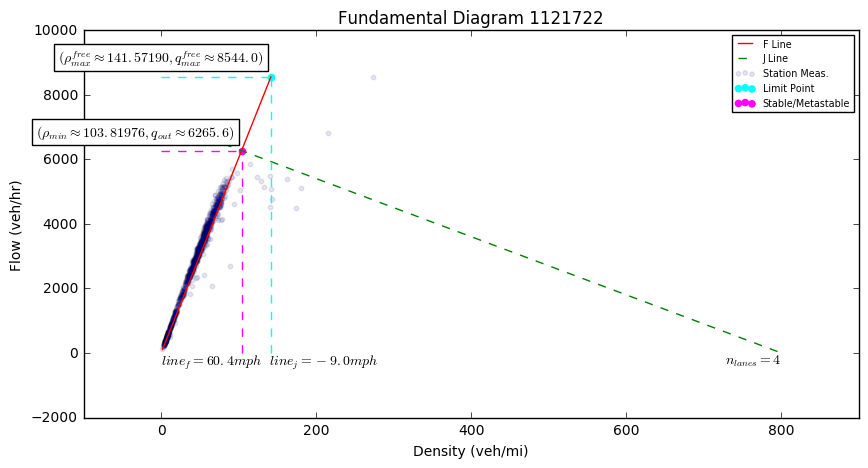

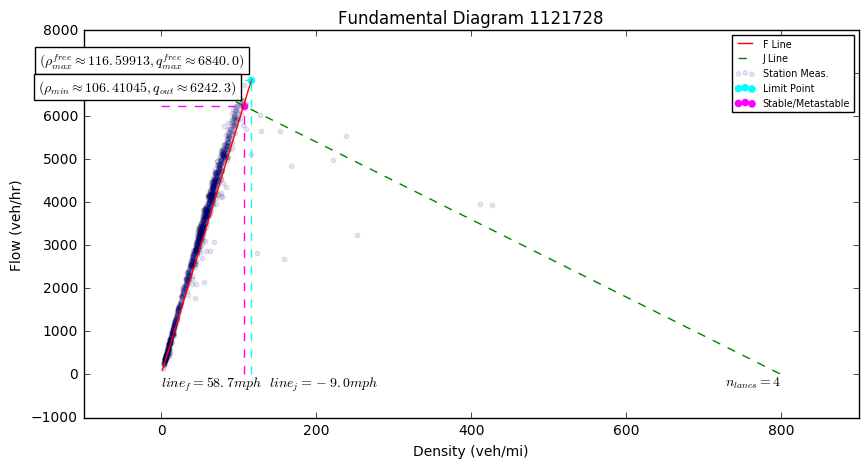

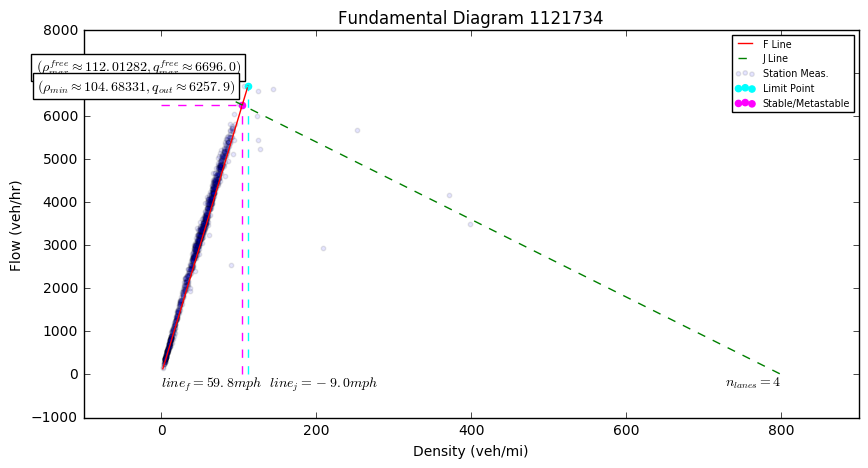

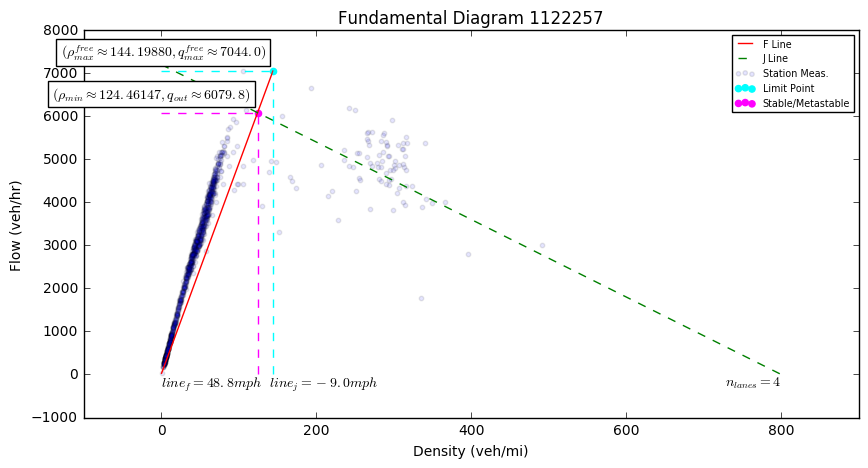

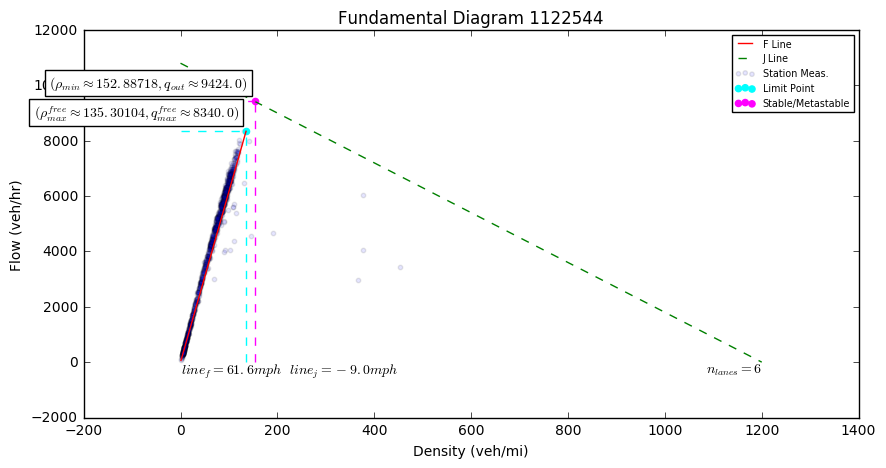

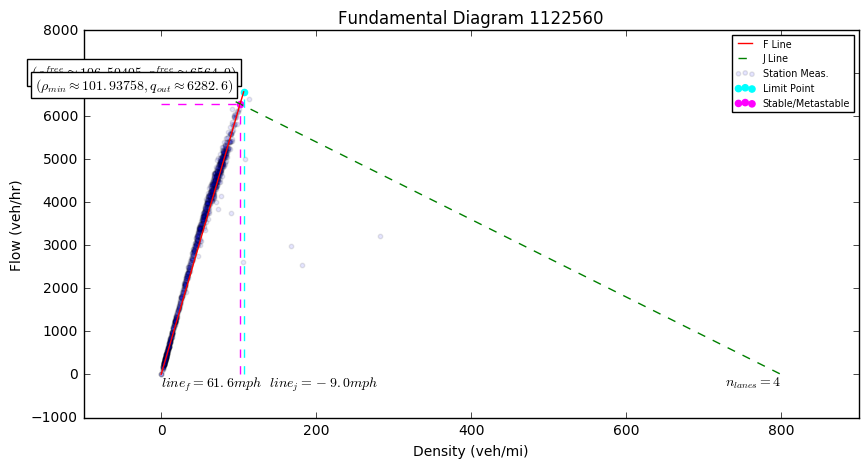

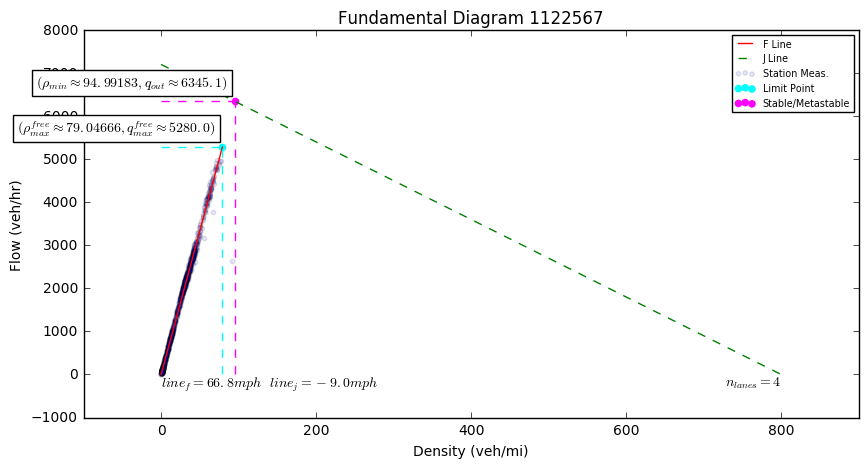

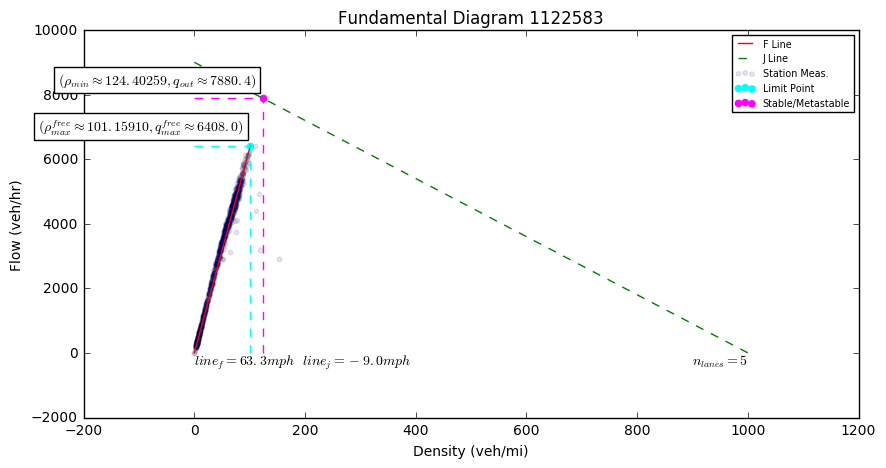

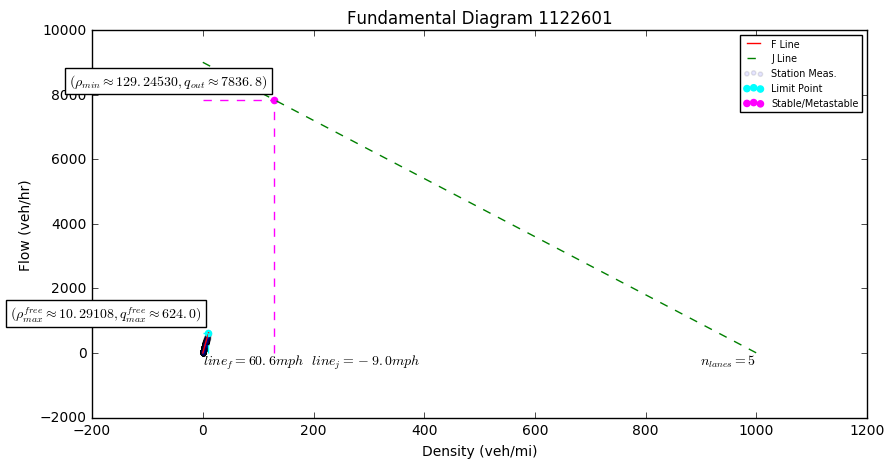

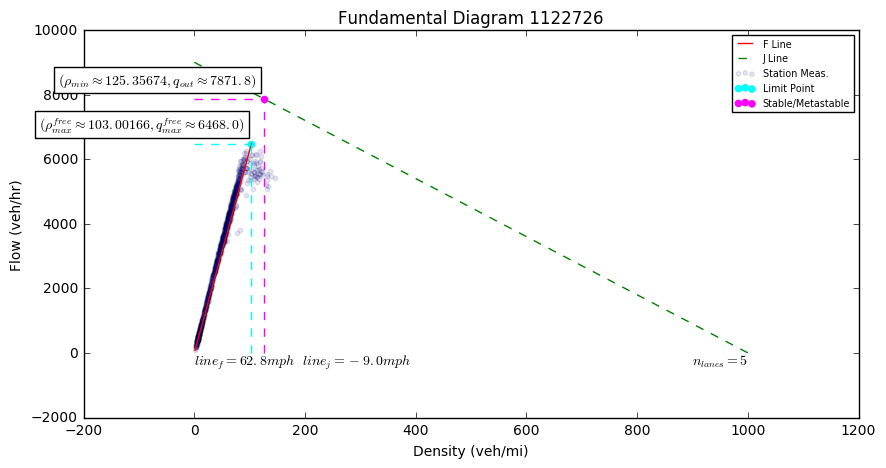

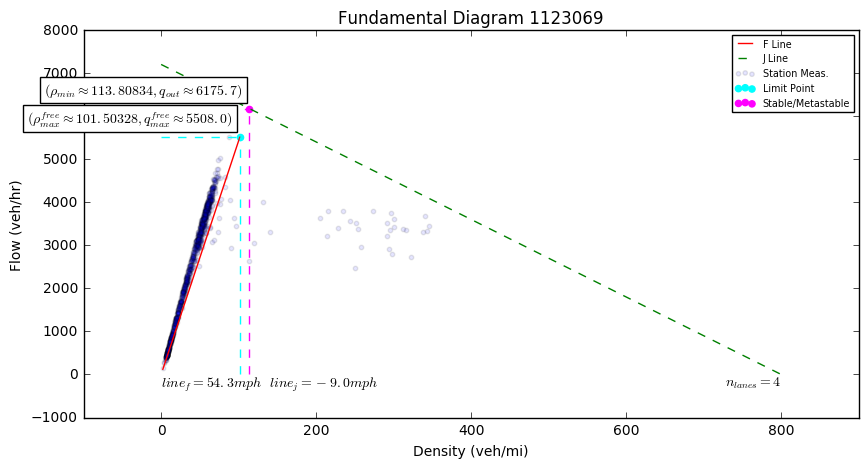

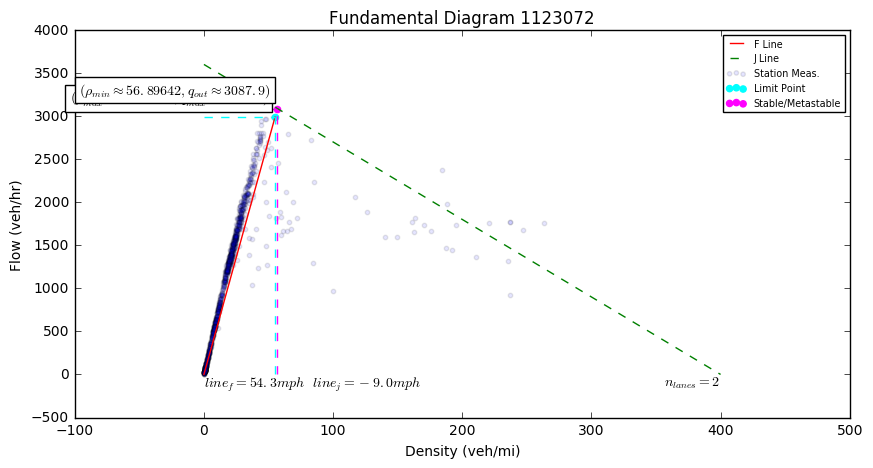

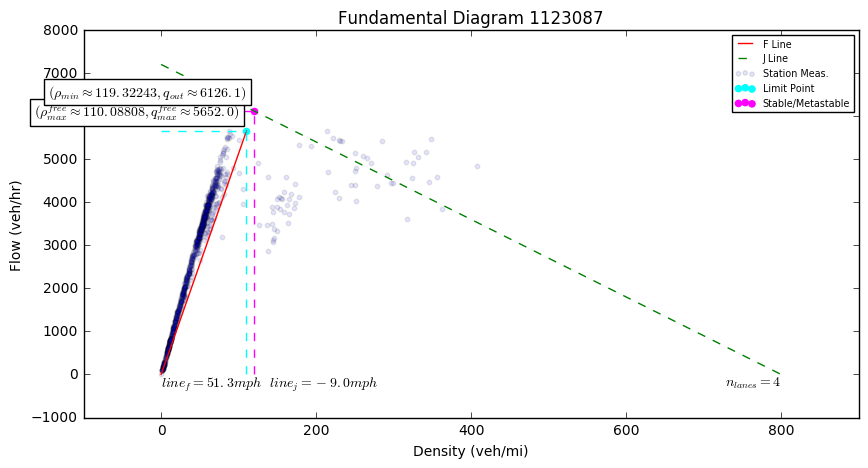

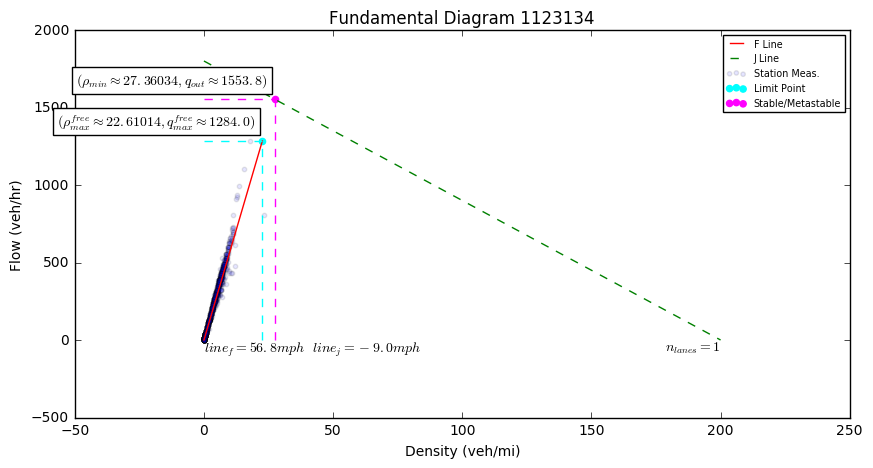

In [404]:
for station in df.Station.unique():
    sub_df, _ = train_test_split( df[df.Station==station], train_size=0.01, random_state=15 )
    plt_fund_diag( sub_df, 'Fundamental Diagram {}'.format(station) )

### Bokeh version (incomplete)

In [67]:
def bk_fund_diag( df, title, to_file=None ):
    flow = df['TotalFlow'] * 12   #convert to cars/hr
    x, y = flow/df['AvgSpeed'], flow
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    idx = df[ df.TotalFlow==(ymax/12) ].index[0]
    
    q_max = ymax
    q_min = ymin
    p_max = x.loc[idx]
    q_out = q_max/1.5
    p_min = p_max/1.5
    
    def line_f( p ):
        f = lambda x: x*(q_max/p_max)
        if type(p)==type([]):
            return map(f, p)
        return f(p)
    
    fx = [xmin, p_max]
    fy = line_f( fx )
    
    jx = [p_min, xmax]
    jy = [q_out, q_min]
    
    fig = bkplot.figure(tools='pan, wheel_zoom, box_zoom, box_select, reset, save')
    fig.scatter( x, y, size=3, color='#3A5785', alpha=0.25 )
    fig.line( fx, fy, color='red' )
    fig.line( jx, jy, color='green' )
    fig.xaxis.axis_label = 'Density (veh/mi)'
    fig.yaxis.axis_label = 'Flow (veh/hr)'
    bkplot.show( fig )

In [99]:
bk_fund_diag( sub_df, 'Test' )